# This notebook describes the lead optimization workflow that evolves a new batch of binders from a parental binder structure

In [1]:
## Default python libraries
import os
import shutil
import glob
import os
import json
import re

from collections import defaultdict
from pathlib import Path
from collections import Counter

## External libraries
import pandas as pd
import numpy as np
import tqdm

pd.set_option('display.max_columns', 500)

## Step 1: Prepare input for SoluableMPNN Mutagenesis

### Step 1.1 Make sure you have a predicted structure where binder is on chain A and target is on chain B
Make sure that the binder is on chain A and the target is on chain B. To do this from BindCraft outputs, use the swap_chain.py util function which will swap the A and B chain of a pdb and renumber them accordingly `python swap_chain.py <binder_pdb> <output_pdb> --renumber`.

Example:
`python workflows/LigandMPNN/swap_chain.py examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_s662851_mpnn3_model2.pdb examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_s662851_mpnn3_model2_chain_swapped.pdb --renumber`

If your structure already has binder on chain A and target on chain B you can skip this step

### Step 1.2 Identify interface residues
This can be done by running `python workflows/LigandMPNN/get_interface_residues.py <binder pdb> A B --cutoff 4 --output_json <output_json>.jsonl`. 
Where `<output_json>.jsonl` will be where the output is stored and `--cutoff 4` defines any residues with atoms within 4 angstrom of another atom in the other chain as interface

Example: `python workflows/LigandMPNN/get_interface_residues.py /data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_s662851_mpnn3_model2_chain_swapped.pdb A B --cutoff 4 --output_json /data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_interface_residues.jsonl`

### Step 1.3 Run the different flavors of MPNN
From here use the bash scripts provided `ProteinMPNN_Binder_Maturation.sh <input_pdb> <interface_residue_jsonl_file> <suffix_name> <output_dir>` to run ProteinMPNN/SoluableMPNN using different settings.

For example:

For mutagenesis of interface residues
`sbatch workflows/LigandMPNN/SoluableMPNN_interface_mutagenesis.sh /data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_s662851_mpnn3_model2_chain_swapped.pdb examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_interface_residues.jsonl "_interface_redesigned" examples/02_lead_candidate_mutagenized/evolved_sequences/interface_redesigned ` 

For mutagenesis of non-interface residues
`sbatch workflows/LigandMPNN/SoluableMPNN_noninterface_mutagenesis.sh /data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_s662851_mpnn3_model2_chain_swapped.pdb examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_interface_residues.jsonl "_non_interface_redesigned" examples/02_lead_candidate_mutagenized/evolved_sequences/noninterface_redesigned ` 

For mutagenesis of all residues
`sbatch workflows/LigandMPNN/SoluableMPNN_all_mutagenesis.sh /data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_s662851_mpnn3_model2_chain_swapped.pdb  examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_interface_residues.jsonl "_all_redesigned" examples/02_lead_candidate_mutagenized/evolved_sequences/all_redesigned ` 

Note that the BATCH_SIZE and NUM_BATCH variable in the scripts should be modified to be multiplied to the number of sequences desired. For example, if you want to do 1000 draws you can set BATCH_SIZE=50 and NUM_BATCH=20. Also note that the full path to the pdb will have to be provided for the residue keys to be matched correctly

Empirically, we see non-interface mpnn draws often have higher in silico success rate than the other two strategies

## Step 2: Inspect SoluableMPNN outputs

In [2]:
def parse_ligandmpnn_fasta(fasta_path,mpnn_type="all"):
    records = []
    with open(fasta_path, 'r') as f:
        current_record = {}
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_record:
                    records.append(current_record)
                    current_record = {}
                # Parse metadata
                header = line[1:]
                fields = header.split(',')
                for field in fields:
                    if '=' in field:
                        key, val = field.strip().split('=', 1)
                        current_record[key.strip()] = val.strip()
                    else:
                        # Handle initial ID field without =
                        current_record['name'] = field.strip()
            else:
                # Split sequence by colon
                if ':' in line:
                    binder_seq, target_seq = line.split(':')
                    current_record['binder_seq'] = binder_seq
                    current_record['target_seq'] = target_seq
                else:
                    current_record['sequence'] = line
        # Append last record
        if current_record:
            records.append(current_record)

    mpnn_df = pd.DataFrame(records)
    mpnn_df["mpnn_type"] = mpnn_type
    return mpnn_df

## Replace these file names with your own
all_redesigned_mpnn_seq_fa = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/evolved_sequences/all_redesigned/seqs/BCMA_l54_s662851_mpnn3_model2_chain_swapped_all_redesigned.fa"
interface_redesigned_mpnn_seq_fa = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/evolved_sequences/interface_redesigned/seqs/BCMA_l54_s662851_mpnn3_model2_chain_swapped_interface_redesigned.fa"
noninterface_redesigned_mpnn_seq_fa = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/evolved_sequences/noninterface_redesigned/seqs/BCMA_l54_s662851_mpnn3_model2_chain_swapped_non_interface_redesigned.fa"

## Parse them accordingly. Optionally name your mpnn strategies
all_mpnn_df = parse_ligandmpnn_fasta(all_redesigned_mpnn_seq_fa,"all")
interface_mpnn_df = parse_ligandmpnn_fasta(interface_redesigned_mpnn_seq_fa,"int")
non_interface_mpnn_df = parse_ligandmpnn_fasta(noninterface_redesigned_mpnn_seq_fa,"nonint")

## Combine MPNN outputs. Replace this list with the ones you wish to include
dfs_to_combine = [all_mpnn_df,interface_mpnn_df,non_interface_mpnn_df]
combined_mpnn_df = pd.concat(dfs_to_combine,ignore_index=True)
combined_mpnn_df["id"] = combined_mpnn_df["id"].fillna("wildtype")
combined_mpnn_df


,name,T,seed,num_res,num_ligand_res,use_ligand_context,ligand_cutoff_distance,batch_size,number_of_batches,model_path,binder_seq,target_seq,id,overall_confidence,ligand_confidence,seq_rec,mpnn_type
0,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,54,54,True,8.0,5,1,/data1/lareauc/users/chuh/softwares/LigandMPNN...,SMEEYQKKMSEFANEITEEAMKDPEKYKEVSWMLNTEEGRYKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,wildtype,NaN,NaN,NaN,all
1,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SSLAELKLLSKYAEKIFNEALKDPKLFEEVSKMLNTEKGRLELLEK...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,1,0.2760,0.2760,0.4630,all
2,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAADKLALLGKEAQQITQDALQNPAEFARVSNMLNTNEGRQQLLQE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,2,0.2641,0.2641,0.3704,all
3,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEAEREELLRREAEKIVNSALTDPEKFATVSHQLQTDEGRKALLKE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,3,0.2772,0.2772,0.4074,all
4,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SASSRQSSLSRVAREVVERALQDPALRQIVSEMLNSEEGRQELLKI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,4,0.2521,0.2521,0.4815,all
5,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SDSEHRALLGKEAEKITKEALEDPEKYSEVSKALNTEQGRKELLKQ...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,5,0.2612,0.2612,0.4630,all
6,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,20,20,True,8.0,5,1,/data1/lareauc/users/chuh/softwares/LigandMPNN...,SMEEYQKKMSEFANEITEEAMKDPEKYKEVSWMLNTEEGRYKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,wildtype,NaN,NaN,NaN,int
7,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMEEKLKKLREFAEEIFTEALKDPEKFKEVSWMLNTEEGKKKLLEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,1,0.3923,0.3923,0.4000,int
8,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMEEYKKKLREFAEEIVNEAMKDPEKFKEVSWMLNTEEGRKKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,2,0.4458,0.4458,0.6000,int
9,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMEEYEKKLREFAEEITNEALKDPEKFKEVSWMLNTEEGREKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,3,0.4102,0.4102,0.6000,int


### Step 2.2 Rename the MPNN draws for clarity

In [4]:
def format_id(x):
    try:
        return f"{int(x):04d}"
    except (ValueError, TypeError):
        return str(x)

combined_mpnn_df["id_str"] = combined_mpnn_df["id"].apply(format_id)

## Replace with your own naming scheme
combined_mpnn_df["mpnn_name_short"] = combined_mpnn_df.apply(lambda row: f"BCMA_{row['mpnn_type']}_{row['id_str']}", axis=1)

## Remove sequence duplicates
combined_mpnn_df = combined_mpnn_df.drop_duplicates("binder_seq").reset_index(drop=True)

## Calculate hamming distance
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strings must be of equal length")
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

og_binder_sequence = combined_mpnn_df[combined_mpnn_df["id"]=="wildtype"]["binder_seq"].iloc[0]
combined_mpnn_df["hamming_to_wildtype"] = combined_mpnn_df["binder_seq"].apply(lambda x: hamming_distance(x,og_binder_sequence))
combined_mpnn_df

/tmp/ipykernel_3291068/2137877362.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mpnn_df["id_str"] = combined_mpnn_df["id"].apply(format_id)
/tmp/ipykernel_3291068/2137877362.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_mpnn_df["mpnn_name_short"] = combined_mpnn_df.apply(lambda row: f"BCMA_{row['mpnn_type']}_{row['id_str']}", axis=1)


,name,T,seed,num_res,num_ligand_res,use_ligand_context,ligand_cutoff_distance,batch_size,number_of_batches,model_path,binder_seq,target_seq,id,overall_confidence,ligand_confidence,seq_rec,mpnn_type,id_str,mpnn_name_short,hamming_to_wildtype
0,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,54,54,True,8.0,5,1,/data1/lareauc/users/chuh/softwares/LigandMPNN...,SMEEYQKKMSEFANEITEEAMKDPEKYKEVSWMLNTEEGRYKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,wildtype,NaN,NaN,NaN,all,wildtype,BCMA_all_wildtype,0
1,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SSLAELKLLSKYAEKIFNEALKDPKLFEEVSKMLNTEKGRLELLEK...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,1,0.2760,0.2760,0.4630,all,0001,BCMA_all_0001,29
2,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAADKLALLGKEAQQITQDALQNPAEFARVSNMLNTNEGRQQLLQE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,2,0.2641,0.2641,0.3704,all,0002,BCMA_all_0002,34
3,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEAEREELLRREAEKIVNSALTDPEKFATVSHQLQTDEGRKALLKE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,3,0.2772,0.2772,0.4074,all,0003,BCMA_all_0003,32
4,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SASSRQSSLSRVAREVVERALQDPALRQIVSEMLNSEEGRQELLKI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,4,0.2521,0.2521,0.4815,all,0004,BCMA_all_0004,28
5,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SDSEHRALLGKEAEKITKEALEDPEKYSEVSKALNTEQGRKELLKQ...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,5,0.2612,0.2612,0.4630,all,0005,BCMA_all_0005,29
6,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMEEKLKKLREFAEEIFTEALKDPEKFKEVSWMLNTEEGKKKLLEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,1,0.3923,0.3923,0.4000,int,0001,BCMA_int_0001,12
7,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMEEYKKKLREFAEEIVNEAMKDPEKFKEVSWMLNTEEGRKKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,2,0.4458,0.4458,0.6000,int,0002,BCMA_int_0002,8
8,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMEEYEKKLREFAEEITNEALKDPEKFKEVSWMLNTEEGREKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,3,0.4102,0.4102,0.6000,int,0003,BCMA_int_0003,8
9,BCMA_l54_s662851_mpnn3_model2_chain_swapped,0.4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SMEEKMKKLSEFAKEIVEEALKDPEKFKEVSWMLDTEEGRKKLKEI...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,4,0.4369,0.4369,0.5500,int,0004,BCMA_int_0004,9


<Axes: xlabel='hamming_to_wildtype', ylabel='Count'>

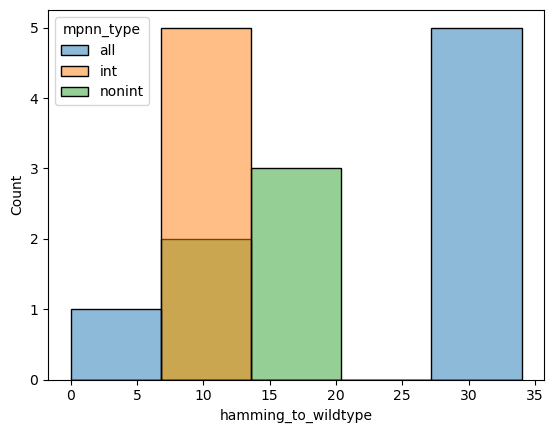

In [12]:
## Inspect the distribution of mutations by evolution strategy
## You can optionally filter out mutated sequences that are too close to parental
## Or perform other sequence-level (ex: immunogenicity) (not shown here)
## just remember to keep at least one parental sequence
import seaborn as sns
sns.histplot(data=combined_mpnn_df,x="hamming_to_wildtype",hue="mpnn_type")

### Step 2.3 Convert this into a boltz pipeline compatible dataframe

In [7]:
# Replace this with your target name
target_name = "BCMA"

combined_mpnn_df["colabfold_id"] = combined_mpnn_df["mpnn_name_short"] + "__" + target_name
combined_mpnn_df["colabfold_sequence"] = combined_mpnn_df["binder_seq"] + ":" + combined_mpnn_df["target_seq"]
colabfold_df = combined_mpnn_df[["colabfold_id","colabfold_sequence"]].rename(columns={
    "colabfold_id":"id",
    "colabfold_sequence":"sequence"
})
colabfold_df

,id,sequence
0,BCMA_all_wildtype__BCMA,SMEEYQKKMSEFANEITEEAMKDPEKYKEVSWMLNTEEGRYKLKEI...
1,BCMA_all_0001__BCMA,SSLAELKLLSKYAEKIFNEALKDPKLFEEVSKMLNTEKGRLELLEK...
2,BCMA_all_0002__BCMA,SAADKLALLGKEAQQITQDALQNPAEFARVSNMLNTNEGRQQLLQE...
3,BCMA_all_0003__BCMA,SEAEREELLRREAEKIVNSALTDPEKFATVSHQLQTDEGRKALLKE...
4,BCMA_all_0004__BCMA,SASSRQSSLSRVAREVVERALQDPALRQIVSEMLNSEEGRQELLKI...
5,BCMA_all_0005__BCMA,SDSEHRALLGKEAEKITKEALEDPEKYSEVSKALNTEQGRKELLKQ...
6,BCMA_int_0001__BCMA,SMEEKLKKLREFAEEIFTEALKDPEKFKEVSWMLNTEEGKKKLLEI...
7,BCMA_int_0002__BCMA,SMEEYKKKLREFAEEIVNEAMKDPEKFKEVSWMLNTEEGRKKLKEI...
8,BCMA_int_0003__BCMA,SMEEYEKKLREFAEEITNEALKDPEKFKEVSWMLNTEEGREKLKEI...
9,BCMA_int_0004__BCMA,SMEEKMKKLSEFAKEIVEEALKDPEKFKEVSWMLDTEEGRKKLKEI...


In [10]:
## Write the csv
## Replace the colab_write_path with your own
colab_write_path = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/colabfold_table.csv"
os.makedirs(os.path.dirname(colab_write_path), exist_ok=True)
colabfold_df.to_csv(colab_write_path,index=False)

## Step 3: Run the Boltz Prediction Pipeline to Obtain Predicted Structures
If you already ran the other notebook then the following steps are identical to the refolding workflow used there.

See the README in the Boltz workflow for more details on how to set it up, but the rough pipeline is:
1. **Run the boltz prediction pipeline to obtain predicted structures and metrics** (`sbatch workflows/Boltz/boltz_pipeline_wrapper_step_02_05_HC.sh <path to colabfold_table.csv> <prediction output directory> <number of jobs to divide into>`)
2. **Calculate ipSAE / pAE interaction / rosetta-based metrics based on the  Boltz outputs** (`sbatch workflows/Boltz/boltz_pipeline_wrapper_step_06_08_HC <boltz prediction output directory>`)
3. **Run the output aggregation script to summarize the outputs per directory** (`sbatch workflows/Boltz/10_aggregate_boltz_outputs.sh <prediction output directory> <aggregated output directory>`)

Example commands:

1. `sbatch workflows/Boltz/boltz_pipeline_wrapper_step_02_05_HC.sh examples/03_lead_mutagenesis_boltz_refolded/input_tables/colabfold_table.csv examples/03_lead_mutagenesis_boltz_refolded/predictions 3`
2. `sbatch workflows/Boltz/boltz_pipeline_wrapper_step_06_08_HC.sh examples/03_lead_mutagenesis_boltz_refolded/predictions/boltz_predictions`
3. `sbatch workflows/Boltz/10_aggregate_boltz_outputs.sh examples/03_lead_mutagenesis_boltz_refolded/predictions/boltz_predictions  examples/03_lead_mutagenesis_boltz_refolded/predictions/boltz_predictions_aggregated`

## Step 4: Load the aggregated outputs

### 4.1 Load the aggregated outputs and add sequence information back into the dataframes

In [13]:
## Replace the aggregation directory with the one specified during the run
agg_dir = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/predictions/boltz_predictions_aggregated"
combined_boltz_df = pd.concat(pd.read_csv(path) for path in glob.glob(f"{agg_dir}/*.csv"))
combined_boltz_df

,prediction_name,pdb_model_name,pdb_path,confidence_path,pae_path,plddt_path,confidence_score,ptm,iptm,ligand_iptm,protein_iptm,complex_plddt,complex_iplddt,complex_pde,complex_ipde,chains_ptm_0,chains_ptm_1,pair_chains_iptm_0_0,pair_chains_iptm_0_1,pair_chains_iptm_1_0,pair_chains_iptm_1_1,pae_all,pae_chain_a,pae_chain_b,pae_interaction,Chn1,Chn2,PAE,Dist,Type,ipSAE,ipSAE_d0chn,ipSAE_d0dom,ipTM_af,ipTM_d0chn,pDockQ,pDockQ2,LIS,n0res,n0chn,n0dom,d0res,d0chn,d0dom,nres1,nres2,dist1,dist2,Model,i_pLDDT,ss_pLDDT,Unrelaxed_Clashes,Relaxed_Clashes,Binder_Energy_Score,Surface_Hydrophobicity,ShapeComplementarity,PackStat,dG,dSASA,dG/dSASA,Interface_SASA_%,Interface_Hydrophobicity,n_InterfaceResidues,n_InterfaceHbonds,InterfaceHbondsPercentage,n_InterfaceUnsatHbonds,InterfaceUnsatHbondsPercentage,InterfaceAAs,Interface_Helix%,Interface_BetaSheet%,Interface_Loop%,Binder_Helix%,Binder_BetaSheet%,Binder_Loop%,binder_path,binder_relaxed_path
0,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_0,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.959881,0.963989,0.961075,0.0,0.961075,0.959583,0.968129,0.265846,0.298681,0.974443,0.974863,0.974443,0.957849,0.961075,0.974863,1.160924,0.900833,0.876666,1.450745,A,B,10,10,max,0.932480,0.968225,0.968225,0.961,0.968225,0.4352,0.9386,0.8793,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.97,0.97,1,0,-133.44,0.20,0.74,0.61,-40.58,1413.94,-2.87,36.52,55.56,18,3,16.67,2.0,11.11,"{'A': 2, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",92.86,0.0,7.14,90.74,0.0,9.26,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...
1,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_3,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.958427,0.958780,0.956131,0.0,0.956131,0.959001,0.969450,0.273216,0.317655,0.969342,0.970455,0.969342,0.952080,0.956131,0.970455,1.311857,0.999460,1.023629,1.642232,A,B,10,10,max,0.921029,0.962891,0.962891,0.956,0.962891,0.4720,0.9416,0.8659,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.98,0.97,0,0,-130.35,0.19,0.71,0.64,-38.27,1436.03,-2.66,36.83,55.56,18,4,22.22,3.0,16.67,"{'A': 2, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",84.62,0.0,15.38,87.04,0.0,12.96,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...
2,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_1,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.959156,0.962644,0.959646,0.0,0.959646,0.959034,0.968954,0.268154,0.305815,0.973322,0.971868,0.973322,0.955448,0.959646,0.971868,1.223446,0.928021,0.951562,1.535643,A,B,10,10,max,0.928060,0.966600,0.966600,0.960,0.966600,0.4376,0.9416,0.8725,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.97,0.97,1,0,-135.05,0.20,0.72,0.53,-38.17,1393.36,-2.74,34.05,52.94,17,3,17.65,2.0,11.76,"{'A': 1, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",92.86,0.0,7.14,90.74,0.0,9.26,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...
3,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_4,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.957721,0.952733,0.947487,0.0,0.947487,0.960279,0.969116,0.282426,0.356948,0.967324,0.964441,0.967324,0.947487,0.945909,0.964441,1.418411,1.039494,1.127935,1.799424,A,B,10,10,max,0.910852,0.953336,0.953336,0.947,0.953336,0.

In [14]:
## This is the input file used for the boltz reprediction 
## Replace the input path with the one provided to the boltz pipeline
colab_input_path = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/colabfold_table.csv"

colab_input_df = pd.read_csv(colab_input_path)
colab_input_df["chain_a_seq"] = colab_input_df["sequence"].apply(lambda x: x.split(":")[0])
colab_input_df["chain_b_seq"] = colab_input_df["sequence"].apply(lambda x: x.split(":")[1])
combined_boltz_df = pd.concat(pd.read_csv(path) for path in glob.glob(f"{agg_dir}/*.csv"))
combined_boltz_df = combined_boltz_df.merge(colab_input_df[["id","chain_a_seq","chain_b_seq"]],left_on="prediction_name",right_on="id",how="left")
combined_boltz_df["binder_name"] = combined_boltz_df["prediction_name"].apply(lambda x: x.split("__")[0])
combined_boltz_df

,prediction_name,pdb_model_name,pdb_path,confidence_path,pae_path,plddt_path,confidence_score,ptm,iptm,ligand_iptm,protein_iptm,complex_plddt,complex_iplddt,complex_pde,complex_ipde,chains_ptm_0,chains_ptm_1,pair_chains_iptm_0_0,pair_chains_iptm_0_1,pair_chains_iptm_1_0,pair_chains_iptm_1_1,pae_all,pae_chain_a,pae_chain_b,pae_interaction,Chn1,Chn2,PAE,Dist,Type,ipSAE,ipSAE_d0chn,ipSAE_d0dom,ipTM_af,ipTM_d0chn,pDockQ,pDockQ2,LIS,n0res,n0chn,n0dom,d0res,d0chn,d0dom,nres1,nres2,dist1,dist2,Model,i_pLDDT,ss_pLDDT,Unrelaxed_Clashes,Relaxed_Clashes,Binder_Energy_Score,Surface_Hydrophobicity,ShapeComplementarity,PackStat,dG,dSASA,dG/dSASA,Interface_SASA_%,Interface_Hydrophobicity,n_InterfaceResidues,n_InterfaceHbonds,InterfaceHbondsPercentage,n_InterfaceUnsatHbonds,InterfaceUnsatHbondsPercentage,InterfaceAAs,Interface_Helix%,Interface_BetaSheet%,Interface_Loop%,Binder_Helix%,Binder_BetaSheet%,Binder_Loop%,binder_path,binder_relaxed_path,id,chain_a_seq,chain_b_seq,binder_name
0,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_0,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.959881,0.963989,0.961075,0.0,0.961075,0.959583,0.968129,0.265846,0.298681,0.974443,0.974863,0.974443,0.957849,0.961075,0.974863,1.160924,0.900833,0.876666,1.450745,A,B,10,10,max,0.932480,0.968225,0.968225,0.961,0.968225,0.4352,0.9386,0.8793,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.97,0.97,1,0,-133.44,0.20,0.74,0.61,-40.58,1413.94,-2.87,36.52,55.56,18,3,16.67,2.0,11.11,"{'A': 2, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",92.86,0.0,7.14,90.74,0.0,9.26,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,BCMA_nonint_0004__BCMA,SKEEYQKQMSEEANKITEEAMKDPEKYKEVSEKLNTEEGRYKLKEE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,BCMA_nonint_0004
1,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_3,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.958427,0.958780,0.956131,0.0,0.956131,0.959001,0.969450,0.273216,0.317655,0.969342,0.970455,0.969342,0.952080,0.956131,0.970455,1.311857,0.999460,1.023629,1.642232,A,B,10,10,max,0.921029,0.962891,0.962891,0.956,0.962891,0.4720,0.9416,0.8659,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.98,0.97,0,0,-130.35,0.19,0.71,0.64,-38.27,1436.03,-2.66,36.83,55.56,18,4,22.22,3.0,16.67,"{'A': 2, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",84.62,0.0,15.38,87.04,0.0,12.96,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,BCMA_nonint_0004__BCMA,SKEEYQKQMSEEANKITEEAMKDPEKYKEVSEKLNTEEGRYKLKEE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,BCMA_nonint_0004
2,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_1,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.959156,0.962644,0.959646,0.0,0.959646,0.959034,0.968954,0.268154,0.305815,0.973322,0.971868,0.973322,0.955448,0.959646,0.971868,1.223446,0.928021,0.951562,1.535643,A,B,10,10,max,0.928060,0.966600,0.966600,0.960,0.966600,0.4376,0.9416,0.8725,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.97,0.97,1,0,-135.05,0.20,0.72,0.53,-38.17,1393.36,-2.74,34.05,52.94,17,3,17.65,2.0,11.76,"{'A': 1, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",92.86,0.0,7.14,90.74,0.0,9.26,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,BCMA_nonint_0004__BCMA,SKEEYQKQMSEEANKITEEAMKDPEKYKEVSEKLNTEEGRYKLKEE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,BCMA_nonint_0004
3,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_4,exam

## Step 4b (Optional): Calculate the monomer lDDT / RMSD of the binders
Sometimes binders could have high interaction metrics but have unrealistic shapes that make them insoluable. To check this, we can fold up the binders as monomers and check their monomer lDDT and how different they look compared to how they are in complex via RMSD.

Since all MPNN draws have the same length, AlphaFold only has to be initalized once and this script will run at normal speed for the first structure (about 200 seconds) but very fast for all subsequent prediction (about 3 seconds per sequence)

### 4b.1: Create the fasta input required for monomer refolding

In [25]:
## Replace fasta_dir with your own. This is where the fasta files wil be written
fasta_dir = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/monomer_fasta"

## This creates a directory containing monomer fastas
def dataframe_to_fasta_and_split(df, output_dir, id_col="Design", seq_col="Sequence", num_parts=5):
    output_dir = Path(output_dir)
    full_fasta_path = output_dir / "binder_monomer.fasta"
    chunk_dir = output_dir / "fasta_chunked"
    chunk_dir.mkdir(parents=True, exist_ok=True)

    # Write full fasta
    entries = [(f">{row[id_col]}", row[seq_col]) for _, row in df.iterrows()]
    with open(full_fasta_path, "w") as f:
        f.write("\n".join(f"{h}\n{s}" for h, s in entries))

    # Split into chunks
    total = len(entries)
    chunk_size = (total + num_parts - 1) // num_parts
    for i in range(num_parts):
        chunk = entries[i*chunk_size : (i+1)*chunk_size]
        with open(chunk_dir / f"part_{i+1}.fasta", "w") as f:
            f.write("\n".join(f"{h}\n{s}" for h, s in chunk))
    print(f"Wrote {total} entries to {full_fasta_path} and {num_parts} chunks in {chunk_dir}")

# The dataframe used and the column names are slighly different from what we did in the previous notebook but the idea is the same
dataframe_to_fasta_and_split(combined_mpnn_df, fasta_dir,id_col="mpnn_name_short",seq_col="binder_seq",num_parts=2)


Wrote 16 entries to /data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/monomer_fasta/binder_monomer.fasta and 2 chunks in /data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/monomer_fasta/fasta_chunked


### 4b.2 Run the monomer refolding script

See the README in the AlphaFold workflow for more details on how to set it up

Run the Single sequence mode AlphaFold script `sbatch run_alphafold_monomer_array.sh <input fasta directory> <output directory>`
where `<input fasta directory>` is a directory containing a list of .fasta files. One job will be launched per fasta file.

Example commands:
- `bash workflows/AlphaFold/run_alphafold_monomer_array.sh /data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/monomer_fasta/fasta_chunked /data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/predictions/af2_monomers`


### 4b.3 Once the monomer folding is done, make a new dataframe that contains both the monomer pdb path and the complex pdb path 

#### 4b.3.1 Load the monomer refolding outputs files


In [26]:
## Replace the directory that contains the monomer outputs with your own
af2_monomer_parental_dir = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/predictions/af2_monomers"

def load_af2_monomer_df(path):
    af2_monomer_dir = os.path.dirname(path)
    af2_monomer_df = pd.read_csv(path)
    af2_monomer_df["monomer_pdb"] = af2_monomer_df["Output_PDB"].apply(lambda x: os.path.join(af2_monomer_dir, x) + ".pdb")
    return af2_monomer_df

## Load in the monomer files
all_af2_monomer_files = glob.glob(os.path.join(af2_monomer_parental_dir, "*part*", "AF2_score.csv"))
af2_monomer_df = pd.concat([load_af2_monomer_df(f) for f in all_af2_monomer_files], ignore_index=True)
af2_monomer_df


,ID,Name,Sequence,Model/Tag,Output_PDB,lDDT,Time,monomer_pdb
0,0,BCMA_int_0003,SMEEYEKKLREFAEEITNEALKDPEKFKEVSWMLNTEEGREKLKEI...,model_4,BCMA_int_0003_model_4.0_r10_af2,82.580,176.3,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
1,1,BCMA_int_0004,SMEEKMKKLSEFAKEIVEEALKDPEKFKEVSWMLDTEEGRKKLKEI...,model_4,BCMA_int_0004_model_4.0_r10_af2,87.194,2.7,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
2,2,BCMA_int_0005,SMEEYKKKLKEFAQEIVLEALKDPEKFKEVSWMLETEEGRKKLKEI...,model_4,BCMA_int_0005_model_4.0_r10_af2,87.637,2.7,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
3,3,BCMA_nonint_0001,SKEQYQGLMSKFANEITEQAMKDPELYKFVSAMLNTEQGRYELKGL...,model_4,BCMA_nonint_0001_model_4.0_r10_af2,92.106,2.7,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
4,4,BCMA_nonint_0002,SKTDYQNEMSKYANEITESAMNNPELYTRVSRMLNTEDGRYKLKEE...,model_4,BCMA_nonint_0002_model_4.0_r10_af2,88.773,3.0,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
5,5,BCMA_nonint_0003,SEEEYQKKMSEEANKVTENAMKNPEEYKRVSEMLNTEEGRYKLKEI...,model_4,BCMA_nonint_0003_model_4.0_r10_af2,91.787,2.7,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
6,6,BCMA_nonint_0004,SKEEYQKQMSEEANKITEEAMKDPEKYKEVSEKLNTEEGRYKLKEE...,model_4,BCMA_nonint_0004_model_4.0_r10_af2,92.065,2.7,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
7,7,BCMA_nonint_0005,TDLEYQKLMSEEANKITEEAMKDPEKYKEVSDMLNTLEGRYELKQV...,model_4,BCMA_nonint_0005_model_4.0_r10_af2,88.163,2.7,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
8,0,BCMA_all_wildtype,SMEEYQKKMSEFANEITEEAMKDPEKYKEVSWMLNTEEGRYKLKEI...,model_4,BCMA_all_wildtype_model_4.0_r10_af2,92.210,188.8,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
9,1,BCMA_all_0001,SSLAELKLLSKYAEKIFNEALKDPKLFEEVSKMLNTEKGRLELLEK...,model_4,BCMA_all_0001_model_4.0_r10_af2,89.799,2.7,/data1/lareauc/users/chuh/softwares/CARPNN/exa...


#### 4b.3.2 Make a merged dataframe that contains the path to both the monomer pdb and the complex pdb

In [27]:
combined_boltz_df["binder_name"] = combined_boltz_df["prediction_name"].apply(lambda x: x.split("__")[0])
combined_boltz_df_subset = combined_boltz_df[["binder_name","pdb_model_name","pdb_path"]].rename(columns={"pdb_path":"binder_path"})
af2_monomer_df_merged = af2_monomer_df.merge(combined_boltz_df_subset,left_on="Name",right_on="binder_name",how="left")
af2_monomer_df_merged_subset = af2_monomer_df_merged[["binder_name","pdb_model_name","binder_path","monomer_pdb"]]
af2_monomer_df_merged_subset

,binder_name,pdb_model_name,binder_path,monomer_pdb
0,BCMA_int_0003,BCMA_int_0003__BCMA_model_3,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
1,BCMA_int_0003,BCMA_int_0003__BCMA_model_4,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
2,BCMA_int_0003,BCMA_int_0003__BCMA_model_2,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
3,BCMA_int_0003,BCMA_int_0003__BCMA_model_0,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
4,BCMA_int_0003,BCMA_int_0003__BCMA_model_1,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
...,...,...,...,...
75,BCMA_int_0002,BCMA_int_0002__BCMA_model_3,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
76,BCMA_int_0002,BCMA_int_0002__BCMA_model_4,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
77,BCMA_int_0002,BCMA_int_0002__BCMA_model_1,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...
78,BCMA_int_0002,BCMA_int_0002__BCMA_model_2,examples/03_lead_mutagenesis_boltz_refolded/pr...,/data1/lareauc/users/chuh/softwares/CARPNN/exa...


In [28]:
## Replace the output path name with your own, this table will be used as input for the next command
rmsd_table_path = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/rmsd_table.csv"

af2_monomer_df_merged_subset.to_csv(rmsd_table_path,index=False)

#### 3b.3.3 Run the RMSD script to compute the RMSD between the monomer pdb vs. binder in complex with target pdb
Run `sbatch 09_run_rmsd <path to rmsd_table> <output path>`

Example:
`sbatch workflows/Boltz/09_run_rmsd.sh examples/03_lead_mutagenesis_boltz_refolded/input_tables/rmsd_table.csv examples/03_lead_mutagenesis_boltz_refolded/input_tables/rmsd_table_monomer.csv`

#### 3.3.4 After the RMSD calculation finishes running, add monomer_lDDT and monomer_RMSD to the dataframe

In [29]:
## Replace path with the output from the pipeline
rmsd_monomer_path = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/03_lead_mutagenesis_boltz_refolded/input_tables/rmsd_table_monomer.csv"

rmsd_monomer = pd.read_csv(rmsd_monomer_path)
rmsd_monomer = rmsd_monomer.rename(columns={"binder_complex_monomer_rmsd":"binder_monomer_RMSD"})
rmsd_merged = rmsd_monomer.merge(af2_monomer_df,on="monomer_pdb")
rmsd_merged_subset = rmsd_merged[["pdb_model_name","lDDT","binder_monomer_RMSD"]].rename(columns={"lDDT":"monomer_lDDT"})
rmsd_merged_subset

,pdb_model_name,monomer_lDDT,binder_monomer_RMSD
0,BCMA_int_0003__BCMA_model_3,82.58,1.503
1,BCMA_int_0003__BCMA_model_4,82.58,1.554
2,BCMA_int_0003__BCMA_model_2,82.58,1.506
3,BCMA_int_0003__BCMA_model_0,82.58,1.498
4,BCMA_int_0003__BCMA_model_1,82.58,1.434
...,...,...,...
75,BCMA_int_0002__BCMA_model_3,84.48,0.659
76,BCMA_int_0002__BCMA_model_4,84.48,0.654
77,BCMA_int_0002__BCMA_model_1,84.48,0.671
78,BCMA_int_0002__BCMA_model_2,84.48,0.750


In [30]:
## Merge the information back to the datafrmae
combined_boltz_df_rmsd_merged = combined_boltz_df.merge(rmsd_merged_subset,on="pdb_model_name",how="left")
combined_boltz_df_rmsd_merged

,prediction_name,pdb_model_name,pdb_path,confidence_path,pae_path,plddt_path,confidence_score,ptm,iptm,ligand_iptm,protein_iptm,complex_plddt,complex_iplddt,complex_pde,complex_ipde,chains_ptm_0,chains_ptm_1,pair_chains_iptm_0_0,pair_chains_iptm_0_1,pair_chains_iptm_1_0,pair_chains_iptm_1_1,pae_all,pae_chain_a,pae_chain_b,pae_interaction,Chn1,Chn2,PAE,Dist,Type,ipSAE,ipSAE_d0chn,ipSAE_d0dom,ipTM_af,ipTM_d0chn,pDockQ,pDockQ2,LIS,n0res,n0chn,n0dom,d0res,d0chn,d0dom,nres1,nres2,dist1,dist2,Model,i_pLDDT,ss_pLDDT,Unrelaxed_Clashes,Relaxed_Clashes,Binder_Energy_Score,Surface_Hydrophobicity,ShapeComplementarity,PackStat,dG,dSASA,dG/dSASA,Interface_SASA_%,Interface_Hydrophobicity,n_InterfaceResidues,n_InterfaceHbonds,InterfaceHbondsPercentage,n_InterfaceUnsatHbonds,InterfaceUnsatHbondsPercentage,InterfaceAAs,Interface_Helix%,Interface_BetaSheet%,Interface_Loop%,Binder_Helix%,Binder_BetaSheet%,Binder_Loop%,binder_path,binder_relaxed_path,id,chain_a_seq,chain_b_seq,binder_name,monomer_lDDT,binder_monomer_RMSD
0,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_0,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.959881,0.963989,0.961075,0.0,0.961075,0.959583,0.968129,0.265846,0.298681,0.974443,0.974863,0.974443,0.957849,0.961075,0.974863,1.160924,0.900833,0.876666,1.450745,A,B,10,10,max,0.932480,0.968225,0.968225,0.961,0.968225,0.4352,0.9386,0.8793,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.97,0.97,1,0,-133.44,0.20,0.74,0.61,-40.58,1413.94,-2.87,36.52,55.56,18,3,16.67,2.0,11.11,"{'A': 2, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",92.86,0.0,7.14,90.74,0.0,9.26,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,BCMA_nonint_0004__BCMA,SKEEYQKQMSEEANKITEEAMKDPEKYKEVSEKLNTEEGRYKLKEE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,BCMA_nonint_0004,92.065,0.649
1,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_3,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.958427,0.958780,0.956131,0.0,0.956131,0.959001,0.969450,0.273216,0.317655,0.969342,0.970455,0.969342,0.952080,0.956131,0.970455,1.311857,0.999460,1.023629,1.642232,A,B,10,10,max,0.921029,0.962891,0.962891,0.956,0.962891,0.4720,0.9416,0.8659,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.98,0.97,0,0,-130.35,0.19,0.71,0.64,-38.27,1436.03,-2.66,36.83,55.56,18,4,22.22,3.0,16.67,"{'A': 2, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",84.62,0.0,15.38,87.04,0.0,12.96,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,BCMA_nonint_0004__BCMA,SKEEYQKQMSEEANKITEEAMKDPEKYKEVSEKLNTEEGRYKLKEE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,BCMA_nonint_0004,92.065,0.702
2,BCMA_nonint_0004__BCMA,BCMA_nonint_0004__BCMA_model_1,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.959156,0.962644,0.959646,0.0,0.959646,0.959034,0.968954,0.268154,0.305815,0.973322,0.971868,0.973322,0.955448,0.959646,0.971868,1.223446,0.928021,0.951562,1.535643,A,B,10,10,max,0.928060,0.966600,0.966600,0.960,0.966600,0.4376,0.9416,0.8725,54,90,90,2.41,3.43,3.43,54,36,31,20,examples/03_lead_mutagenesis_boltz_refolded/pr...,0.97,0.97,1,0,-135.05,0.20,0.72,0.53,-38.17,1393.36,-2.74,34.05,52.94,17,3,17.65,2.0,11.76,"{'A': 1, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': ...",92.86,0.0,7.14,90.74,0.0,9.26,examples/03_lead_mutagenesis_boltz_refolded/pr...,examples/03_lead_mutagenesis_boltz_refolded/pr...,BCMA_nonint_0004__BCMA,SKEEYQKQMSEEANKITEEAMKDPEKYKEVSEKLNTEEGRYKLKEE...,CSQNEYFDSLLHACIPCQLRCSSNTPPLTCQRYCNA,BCMA_nonint_0004,9

### 4.4 Transform the long-form prediction outputs into a BindCraft style wide-form format
These functions will convert the table from one prediction per row to one sequence per row where each sequence now has the additional columns for each prediciton

In [31]:
def sort_columns_by_feature_group(col_list):
    '''
    This is a helper function that sorts the column numerically
    '''
    grouped = defaultdict(list)
    for col in col_list:
        parts = col.split("_", 1)
        rest = parts[1] if len(parts) > 1 else parts[0]
        match = re.match(r"([a-zA-Z0-9_%]+)", rest)
        base = match.group(1) if match else rest
        grouped[base].append(col)

    def numeric_suffix_sort_key(name):
        nums = re.findall(r'\d+', name)
        return [int(n) for n in nums] if nums else [float('inf')]

    sorted_col_groups = {}
    for base in sorted(grouped.keys()):
        sorted_group = sorted(grouped[base], key=numeric_suffix_sort_key)
        sorted_col_groups[base] = sorted_group
    return sorted_col_groups

def average_dicts_across_columns(df, cols):
    '''
    This is a helper function that computes the 'Average' column across prediction columns
    '''
    all_keys = set()

    def safe_dict(d):
        if isinstance(d, dict):
            return d
        try:
            return ast.literal_eval(d)
        except:
            return {}

    for col in cols:
        all_keys.update(*df[col].dropna().apply(lambda d: safe_dict(d).keys()))

    def average_dicts(row):
        agg = {k: [] for k in all_keys}
        for col in cols:
            d = safe_dict(row[col])
            for k, v in d.items():
                agg[k].append(v)
        return {k: float(np.mean(v)) if v else 0.0 for k, v in agg.items()}

    return df[cols].apply(average_dicts, axis=1)

def boltz_to_bindcraft_df(df):
    '''
    This is the main function that converts the prediction table into a BindCraft-like format
    Adjust the columns included for naming updates / missing information if needed.
    For example: If you did not run the monomer refolding, omit the rmsd_columns
    '''
    boltz_columns = [
        "confidence_score","ptm","iptm","ligand_iptm","protein_iptm",
        "complex_plddt","complex_iplddt","complex_pde","complex_ipde",
        "chains_ptm_0","chains_ptm_1",
        "pair_chains_iptm_0_0","pair_chains_iptm_0_1","pair_chains_iptm_1_0","pair_chains_iptm_1_1"
    ]
    bindcraft_columns = [
        "i_pLDDT","ss_pLDDT","Unrelaxed_Clashes","Relaxed_Clashes","Binder_Energy_Score",
        "Surface_Hydrophobicity","ShapeComplementarity","PackStat","dG","dSASA","dG/dSASA",
        "Interface_SASA_%","Interface_Hydrophobicity","n_InterfaceResidues","n_InterfaceHbonds",
        "InterfaceHbondsPercentage","n_InterfaceUnsatHbonds","InterfaceUnsatHbondsPercentage",
        "InterfaceAAs","Interface_Helix%","Interface_BetaSheet%","Interface_Loop%","Binder_Helix%",
        "Binder_BetaSheet%","Binder_Loop%"
    ]
    rmsd_columns = [
        "binder_monomer_RMSD","monomer_lDDT"
    ]
    ipsae_columns = [
        "ipSAE","ipSAE_d0chn","ipSAE_d0dom","ipTM_af","ipTM_d0chn","pDockQ","pDockQ2","LIS"
    ]
    pae_columns = [
        "pae_all","pae_chain_a","pae_chain_b","pae_interaction"
    ]
    ## If you want normalized pAE, you can also divide the pAE columns by 31.5
    ## Fun fact: BindCraft ipAE was normalized by 31
    #df[pae_columns] = df[pae_columns]/31.5
    columns_to_melt = boltz_columns + ipsae_columns + pae_columns + rmsd_columns + bindcraft_columns 

    df["Model"] = df["pdb_model_name"].apply(lambda x: int(x.split("_model_")[1][0]))
    ## For human readability we increment the model numbers by 1
    df["Model_str"] = df["Model"].apply(lambda x: str(x+1))

    df_long = df.melt(id_vars=['prediction_name', 'Model_str'], value_vars=columns_to_melt,
                      var_name='measurement', value_name='value')

    df_wide = df_long.pivot(index='prediction_name', columns=['Model_str', "measurement"], values='value')
    df_wide.columns = ['_'.join(col).rstrip("_") for col in df_wide.columns]
    sorted_col_groups = sort_columns_by_feature_group(df_wide.columns)
    blocks = []
    for base, cols in sorted_col_groups.items():
        block = df_wide[cols].copy()
        if base == "InterfaceAAs":
            avg_series = average_dicts_across_columns(block, cols)
        else:
            avg_series = block.mean(axis=1)

        block.insert(0, f"Average_{base.rstrip('_')}", avg_series)
        blocks.append(block)
    concat_df = pd.concat(blocks, axis=1).reset_index()
    return concat_df


In [32]:
## Convert the long format merged dataframe into boltz wide format
boltz_bindcraft_style_df = boltz_to_bindcraft_df(combined_boltz_df_rmsd_merged)

## If the monomer columns are not given, remove the RMSD columns in the boltz_to_bindcraft_df function and run this line instead
# boltz_bindcraft_style_df = boltz_to_bindcraft_df(combined_boltz_df)

boltz_bindcraft_style_df


,prediction_name,Average_Binder_BetaSheet%,1_Binder_BetaSheet%,2_Binder_BetaSheet%,3_Binder_BetaSheet%,4_Binder_BetaSheet%,5_Binder_BetaSheet%,Average_Binder_Energy_Score,1_Binder_Energy_Score,2_Binder_Energy_Score,3_Binder_Energy_Score,4_Binder_Energy_Score,5_Binder_Energy_Score,Average_Binder_Helix%,1_Binder_Helix%,2_Binder_Helix%,3_Binder_Helix%,4_Binder_Helix%,5_Binder_Helix%,Average_Binder_Loop%,1_Binder_Loop%,2_Binder_Loop%,3_Binder_Loop%,4_Binder_Loop%,5_Binder_Loop%,Average_InterfaceAAs,1_InterfaceAAs,2_InterfaceAAs,3_InterfaceAAs,4_InterfaceAAs,5_InterfaceAAs,Average_InterfaceHbondsPercentage,1_InterfaceHbondsPercentage,2_InterfaceHbondsPercentage,3_InterfaceHbondsPercentage,4_InterfaceHbondsPercentage,5_InterfaceHbondsPercentage,Average_InterfaceUnsatHbondsPercentage,1_InterfaceUnsatHbondsPercentage,2_InterfaceUnsatHbondsPercentage,3_InterfaceUnsatHbondsPercentage,4_InterfaceUnsatHbondsPercentage,5_InterfaceUnsatHbondsPercentage,Average_Interface_BetaSheet%,1_Interface_BetaSheet%,2_Interface_BetaSheet%,3_Interface_BetaSheet%,4_Interface_BetaSheet%,5_Interface_BetaSheet%,Average_Interface_Helix%,1_Interface_Helix%,2_Interface_Helix%,3_Interface_Helix%,4_Interface_Helix%,5_Interface_Helix%,Average_Interface_Hydrophobicity,1_Interface_Hydrophobicity,2_Interface_Hydrophobicity,3_Interface_Hydrophobicity,4_Interface_Hydrophobicity,5_Interface_Hydrophobicity,Average_Interface_Loop%,1_Interface_Loop%,2_Interface_Loop%,3_Interface_Loop%,4_Interface_Loop%,5_Interface_Loop%,Average_Interface_SASA_%,1_Interface_SASA_%,2_Interface_SASA_%,3_Interface_SASA_%,4_Interface_SASA_%,5_Interface_SASA_%,Average_LIS,1_LIS,2_LIS,3_LIS,4_LIS,5_LIS,Average_PackStat,1_PackStat,2_PackStat,3_PackStat,4_PackStat,5_PackStat,Average_Relaxed_Clashes,1_Relaxed_Clashes,2_Relaxed_Clashes,3_Relaxed_Clashes,4_Relaxed_Clashes,5_Relaxed_Clashes,Average_ShapeComplementarity,1_ShapeComplementarity,2_ShapeComplementarity,3_ShapeComplementarity,4_ShapeComplementarity,5_ShapeComplementarity,Average_Surface_Hydrophobicity,1_Surface_Hydrophobicity,2_Surface_Hydrophobicity,3_Surface_Hydrophobicity,4_Surface_Hydrophobicity,5_Surface_Hydrophobicity,Average_Unrelaxed_Clashes,1_Unrelaxed_Clashes,2_Unrelaxed_Clashes,3_Unrelaxed_Clashes,4_Unrelaxed_Clashes,5_Unrelaxed_Clashes,Average_binder_monomer_RMSD,1_binder_monomer_RMSD,2_binder_monomer_RMSD,3_binder_monomer_RMSD,4_binder_monomer_RMSD,5_binder_monomer_RMSD,Average_chains_ptm_0,1_chains_ptm_0,2_chains_ptm_0,3_chains_ptm_0,4_chains_ptm_0,5_chains_ptm_0,Average_chains_ptm_1,1_chains_ptm_1,2_chains_ptm_1,3_chains_ptm_1,4_chains_ptm_1,5_chains_ptm_1,Average_complex_ipde,1_complex_ipde,2_complex_ipde,3_complex_ipde,4_complex_ipde,5_complex_ipde,Average_complex_iplddt,1_complex_iplddt,2_complex_iplddt,3_complex_iplddt,4_complex_iplddt,5_complex_iplddt,Average_complex_pde,1_complex_pde,2_complex_pde,3_complex_pde,4_complex_pde,5_complex_pde,Average_complex_plddt,1_complex_plddt,2_complex_plddt,3_complex_plddt,4_complex_plddt,5_complex_plddt,Average_confidence_score,1_confidence_score,2_confidence_score,3_confidence_score,4_confidence_score,5_confidence_score,Average_dG,1_dG,1_dG/dSASA,2_dG,2_dG/dSASA,3_dG,3_dG/dSASA,4_dG,4_dG/dSASA,5_dG,5_dG/dSASA,Average_dSASA,1_dSASA,2_dSASA,3_dSASA,4_dSASA,5_dSASA,Average_i_pLDDT,1_i_pLDDT,2_i_pLDDT,3_i_pLDDT,4_i_pLDDT,5_i_pLDDT,Average_ipSAE,1_ipSAE,2_ipSAE,3_ipSAE,4_ipSAE,5_ipSAE,Average_ipSAE_d0chn,1_ipSAE_d0chn,2_ipSAE_d0chn,3_ipSAE_d0chn,4_ipSAE_d0chn,5_ipSAE_d0chn,Average_ipSAE_d0dom,1_ipSAE_d0dom,2_ipSAE_d0dom,3_ipSAE_d0dom,4_ipSAE_d0dom,5_ipSAE_d0dom,Average_ipTM_af,1_ipTM_af,2_ipTM_af,3_ipTM_af,4_ipTM_af,5_ipTM_af,Average_ipTM_d0chn,1_ipTM_d0chn,2_ipTM_d0chn,3_ipTM_d0chn,4_ipTM_d0chn,5_ipTM_d0chn,Average_iptm,1_iptm,2_iptm,3_iptm,4_iptm,5_iptm,Average_ligand_iptm,1_ligand_iptm,2_ligand_iptm,3_ligand_iptm,4_ligand_iptm,5_ligand_iptm,Average_monomer_lDDT,1_monomer_lDDT,2_monomer_lDDT,3_monomer_lDDT,4_monomer_lDDT,5_monomer_lDDT,Average_n_InterfaceHbonds,1_n_InterfaceHbonds,2_n_In

In [33]:
## Add sequence information
boltz_bindcraft_style_df["binder_name"] = boltz_bindcraft_style_df["prediction_name"].apply(lambda x: x.split("__")[0])
boltz_bindcraft_style_df = boltz_bindcraft_style_df.merge(combined_boltz_df[["binder_name","chain_a_seq"]].drop_duplicates(),on="binder_name")
boltz_bindcraft_style_df

,prediction_name,Average_Binder_BetaSheet%,1_Binder_BetaSheet%,2_Binder_BetaSheet%,3_Binder_BetaSheet%,4_Binder_BetaSheet%,5_Binder_BetaSheet%,Average_Binder_Energy_Score,1_Binder_Energy_Score,2_Binder_Energy_Score,3_Binder_Energy_Score,4_Binder_Energy_Score,5_Binder_Energy_Score,Average_Binder_Helix%,1_Binder_Helix%,2_Binder_Helix%,3_Binder_Helix%,4_Binder_Helix%,5_Binder_Helix%,Average_Binder_Loop%,1_Binder_Loop%,2_Binder_Loop%,3_Binder_Loop%,4_Binder_Loop%,5_Binder_Loop%,Average_InterfaceAAs,1_InterfaceAAs,2_InterfaceAAs,3_InterfaceAAs,4_InterfaceAAs,5_InterfaceAAs,Average_InterfaceHbondsPercentage,1_InterfaceHbondsPercentage,2_InterfaceHbondsPercentage,3_InterfaceHbondsPercentage,4_InterfaceHbondsPercentage,5_InterfaceHbondsPercentage,Average_InterfaceUnsatHbondsPercentage,1_InterfaceUnsatHbondsPercentage,2_InterfaceUnsatHbondsPercentage,3_InterfaceUnsatHbondsPercentage,4_InterfaceUnsatHbondsPercentage,5_InterfaceUnsatHbondsPercentage,Average_Interface_BetaSheet%,1_Interface_BetaSheet%,2_Interface_BetaSheet%,3_Interface_BetaSheet%,4_Interface_BetaSheet%,5_Interface_BetaSheet%,Average_Interface_Helix%,1_Interface_Helix%,2_Interface_Helix%,3_Interface_Helix%,4_Interface_Helix%,5_Interface_Helix%,Average_Interface_Hydrophobicity,1_Interface_Hydrophobicity,2_Interface_Hydrophobicity,3_Interface_Hydrophobicity,4_Interface_Hydrophobicity,5_Interface_Hydrophobicity,Average_Interface_Loop%,1_Interface_Loop%,2_Interface_Loop%,3_Interface_Loop%,4_Interface_Loop%,5_Interface_Loop%,Average_Interface_SASA_%,1_Interface_SASA_%,2_Interface_SASA_%,3_Interface_SASA_%,4_Interface_SASA_%,5_Interface_SASA_%,Average_LIS,1_LIS,2_LIS,3_LIS,4_LIS,5_LIS,Average_PackStat,1_PackStat,2_PackStat,3_PackStat,4_PackStat,5_PackStat,Average_Relaxed_Clashes,1_Relaxed_Clashes,2_Relaxed_Clashes,3_Relaxed_Clashes,4_Relaxed_Clashes,5_Relaxed_Clashes,Average_ShapeComplementarity,1_ShapeComplementarity,2_ShapeComplementarity,3_ShapeComplementarity,4_ShapeComplementarity,5_ShapeComplementarity,Average_Surface_Hydrophobicity,1_Surface_Hydrophobicity,2_Surface_Hydrophobicity,3_Surface_Hydrophobicity,4_Surface_Hydrophobicity,5_Surface_Hydrophobicity,Average_Unrelaxed_Clashes,1_Unrelaxed_Clashes,2_Unrelaxed_Clashes,3_Unrelaxed_Clashes,4_Unrelaxed_Clashes,5_Unrelaxed_Clashes,Average_binder_monomer_RMSD,1_binder_monomer_RMSD,2_binder_monomer_RMSD,3_binder_monomer_RMSD,4_binder_monomer_RMSD,5_binder_monomer_RMSD,Average_chains_ptm_0,1_chains_ptm_0,2_chains_ptm_0,3_chains_ptm_0,4_chains_ptm_0,5_chains_ptm_0,Average_chains_ptm_1,1_chains_ptm_1,2_chains_ptm_1,3_chains_ptm_1,4_chains_ptm_1,5_chains_ptm_1,Average_complex_ipde,1_complex_ipde,2_complex_ipde,3_complex_ipde,4_complex_ipde,5_complex_ipde,Average_complex_iplddt,1_complex_iplddt,2_complex_iplddt,3_complex_iplddt,4_complex_iplddt,5_complex_iplddt,Average_complex_pde,1_complex_pde,2_complex_pde,3_complex_pde,4_complex_pde,5_complex_pde,Average_complex_plddt,1_complex_plddt,2_complex_plddt,3_complex_plddt,4_complex_plddt,5_complex_plddt,Average_confidence_score,1_confidence_score,2_confidence_score,3_confidence_score,4_confidence_score,5_confidence_score,Average_dG,1_dG,1_dG/dSASA,2_dG,2_dG/dSASA,3_dG,3_dG/dSASA,4_dG,4_dG/dSASA,5_dG,5_dG/dSASA,Average_dSASA,1_dSASA,2_dSASA,3_dSASA,4_dSASA,5_dSASA,Average_i_pLDDT,1_i_pLDDT,2_i_pLDDT,3_i_pLDDT,4_i_pLDDT,5_i_pLDDT,Average_ipSAE,1_ipSAE,2_ipSAE,3_ipSAE,4_ipSAE,5_ipSAE,Average_ipSAE_d0chn,1_ipSAE_d0chn,2_ipSAE_d0chn,3_ipSAE_d0chn,4_ipSAE_d0chn,5_ipSAE_d0chn,Average_ipSAE_d0dom,1_ipSAE_d0dom,2_ipSAE_d0dom,3_ipSAE_d0dom,4_ipSAE_d0dom,5_ipSAE_d0dom,Average_ipTM_af,1_ipTM_af,2_ipTM_af,3_ipTM_af,4_ipTM_af,5_ipTM_af,Average_ipTM_d0chn,1_ipTM_d0chn,2_ipTM_d0chn,3_ipTM_d0chn,4_ipTM_d0chn,5_ipTM_d0chn,Average_iptm,1_iptm,2_iptm,3_iptm,4_iptm,5_iptm,Average_ligand_iptm,1_ligand_iptm,2_ligand_iptm,3_ligand_iptm,4_ligand_iptm,5_ligand_iptm,Average_monomer_lDDT,1_monomer_lDDT,2_monomer_lDDT,3_monomer_lDDT,4_monomer_lDDT,5_monomer_lDDT,Average_n_InterfaceHbonds,1_n_InterfaceHbonds,2_n_In

In [34]:
## Add additional binder_metrics like charge and distance from parental
## Calculate the net charge of the binder
def net_charge(seq, pH=7.4):
    pKa = {
        'C_term': 3.1, 'N_term': 8.0,
        'D': 3.9, 'E': 4.1, 'C': 8.3, 'Y': 10.1,
        'H': 6.0, 'K': 10.5, 'R': 12.5
    }
    counts = Counter(seq)
    neg = sum(counts[aa] * (1 / (1 + 10**(pKa[aa] - pH))) for aa in ['D', 'E', 'C', 'Y'])
    pos = sum(counts[aa] * (1 / (1 + 10**(pH - pKa[aa]))) for aa in ['H', 'K', 'R'])
    pos += 1 / (1 + 10**(pH - pKa['N_term']))
    neg += 1 / (1 + 10**(pKa['C_term'] - pH))
    return pos - neg

## Calculate hamming distance. ALready defined ealier but defining it again for clarity
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strings must be of equal length")
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

## Replace with your parental prediction name    
parental_prediction_name = "BCMA_all_wildtype__BCMA"

og_binder_sequence = boltz_bindcraft_style_df[boltz_bindcraft_style_df["prediction_name"]==parental_prediction_name]["chain_a_seq"].item()
boltz_bindcraft_style_df["binder_seq_net_charge"] = boltz_bindcraft_style_df["chain_a_seq"].apply(net_charge)
boltz_bindcraft_style_df["hamming_to_wildtype"] = boltz_bindcraft_style_df["chain_a_seq"].apply(lambda x: hamming_distance(x,og_binder_sequence))
boltz_bindcraft_style_df

,prediction_name,Average_Binder_BetaSheet%,1_Binder_BetaSheet%,2_Binder_BetaSheet%,3_Binder_BetaSheet%,4_Binder_BetaSheet%,5_Binder_BetaSheet%,Average_Binder_Energy_Score,1_Binder_Energy_Score,2_Binder_Energy_Score,3_Binder_Energy_Score,4_Binder_Energy_Score,5_Binder_Energy_Score,Average_Binder_Helix%,1_Binder_Helix%,2_Binder_Helix%,3_Binder_Helix%,4_Binder_Helix%,5_Binder_Helix%,Average_Binder_Loop%,1_Binder_Loop%,2_Binder_Loop%,3_Binder_Loop%,4_Binder_Loop%,5_Binder_Loop%,Average_InterfaceAAs,1_InterfaceAAs,2_InterfaceAAs,3_InterfaceAAs,4_InterfaceAAs,5_InterfaceAAs,Average_InterfaceHbondsPercentage,1_InterfaceHbondsPercentage,2_InterfaceHbondsPercentage,3_InterfaceHbondsPercentage,4_InterfaceHbondsPercentage,5_InterfaceHbondsPercentage,Average_InterfaceUnsatHbondsPercentage,1_InterfaceUnsatHbondsPercentage,2_InterfaceUnsatHbondsPercentage,3_InterfaceUnsatHbondsPercentage,4_InterfaceUnsatHbondsPercentage,5_InterfaceUnsatHbondsPercentage,Average_Interface_BetaSheet%,1_Interface_BetaSheet%,2_Interface_BetaSheet%,3_Interface_BetaSheet%,4_Interface_BetaSheet%,5_Interface_BetaSheet%,Average_Interface_Helix%,1_Interface_Helix%,2_Interface_Helix%,3_Interface_Helix%,4_Interface_Helix%,5_Interface_Helix%,Average_Interface_Hydrophobicity,1_Interface_Hydrophobicity,2_Interface_Hydrophobicity,3_Interface_Hydrophobicity,4_Interface_Hydrophobicity,5_Interface_Hydrophobicity,Average_Interface_Loop%,1_Interface_Loop%,2_Interface_Loop%,3_Interface_Loop%,4_Interface_Loop%,5_Interface_Loop%,Average_Interface_SASA_%,1_Interface_SASA_%,2_Interface_SASA_%,3_Interface_SASA_%,4_Interface_SASA_%,5_Interface_SASA_%,Average_LIS,1_LIS,2_LIS,3_LIS,4_LIS,5_LIS,Average_PackStat,1_PackStat,2_PackStat,3_PackStat,4_PackStat,5_PackStat,Average_Relaxed_Clashes,1_Relaxed_Clashes,2_Relaxed_Clashes,3_Relaxed_Clashes,4_Relaxed_Clashes,5_Relaxed_Clashes,Average_ShapeComplementarity,1_ShapeComplementarity,2_ShapeComplementarity,3_ShapeComplementarity,4_ShapeComplementarity,5_ShapeComplementarity,Average_Surface_Hydrophobicity,1_Surface_Hydrophobicity,2_Surface_Hydrophobicity,3_Surface_Hydrophobicity,4_Surface_Hydrophobicity,5_Surface_Hydrophobicity,Average_Unrelaxed_Clashes,1_Unrelaxed_Clashes,2_Unrelaxed_Clashes,3_Unrelaxed_Clashes,4_Unrelaxed_Clashes,5_Unrelaxed_Clashes,Average_binder_monomer_RMSD,1_binder_monomer_RMSD,2_binder_monomer_RMSD,3_binder_monomer_RMSD,4_binder_monomer_RMSD,5_binder_monomer_RMSD,Average_chains_ptm_0,1_chains_ptm_0,2_chains_ptm_0,3_chains_ptm_0,4_chains_ptm_0,5_chains_ptm_0,Average_chains_ptm_1,1_chains_ptm_1,2_chains_ptm_1,3_chains_ptm_1,4_chains_ptm_1,5_chains_ptm_1,Average_complex_ipde,1_complex_ipde,2_complex_ipde,3_complex_ipde,4_complex_ipde,5_complex_ipde,Average_complex_iplddt,1_complex_iplddt,2_complex_iplddt,3_complex_iplddt,4_complex_iplddt,5_complex_iplddt,Average_complex_pde,1_complex_pde,2_complex_pde,3_complex_pde,4_complex_pde,5_complex_pde,Average_complex_plddt,1_complex_plddt,2_complex_plddt,3_complex_plddt,4_complex_plddt,5_complex_plddt,Average_confidence_score,1_confidence_score,2_confidence_score,3_confidence_score,4_confidence_score,5_confidence_score,Average_dG,1_dG,1_dG/dSASA,2_dG,2_dG/dSASA,3_dG,3_dG/dSASA,4_dG,4_dG/dSASA,5_dG,5_dG/dSASA,Average_dSASA,1_dSASA,2_dSASA,3_dSASA,4_dSASA,5_dSASA,Average_i_pLDDT,1_i_pLDDT,2_i_pLDDT,3_i_pLDDT,4_i_pLDDT,5_i_pLDDT,Average_ipSAE,1_ipSAE,2_ipSAE,3_ipSAE,4_ipSAE,5_ipSAE,Average_ipSAE_d0chn,1_ipSAE_d0chn,2_ipSAE_d0chn,3_ipSAE_d0chn,4_ipSAE_d0chn,5_ipSAE_d0chn,Average_ipSAE_d0dom,1_ipSAE_d0dom,2_ipSAE_d0dom,3_ipSAE_d0dom,4_ipSAE_d0dom,5_ipSAE_d0dom,Average_ipTM_af,1_ipTM_af,2_ipTM_af,3_ipTM_af,4_ipTM_af,5_ipTM_af,Average_ipTM_d0chn,1_ipTM_d0chn,2_ipTM_d0chn,3_ipTM_d0chn,4_ipTM_d0chn,5_ipTM_d0chn,Average_iptm,1_iptm,2_iptm,3_iptm,4_iptm,5_iptm,Average_ligand_iptm,1_ligand_iptm,2_ligand_iptm,3_ligand_iptm,4_ligand_iptm,5_ligand_iptm,Average_monomer_lDDT,1_monomer_lDDT,2_monomer_lDDT,3_monomer_lDDT,4_monomer_lDDT,5_monomer_lDDT,Average_n_InterfaceHbonds,1_n_InterfaceHbonds,2_n_In

## Step 5: Apply BindCraft filter on Boltz outputs

In [35]:
## Makes sure the filter applied is correct
def apply_bindcraft_filter(df, json_filters_path=None, json_filters=None):
    if json_filters is None:
        with open(json_filters_path, "r") as file:
            json_filters = json.load(file)
    unmet_conditions = []
    for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
        unmet_conditions.append(check_row_pass_filter(row, json_filters))
    df["unmet_conditions"] = unmet_conditions
    return df

## Makes sure the filter applied is correct
def check_row_pass_filter(row, filter_json):
    unmet_conditions = []
    # Check filters against thresholds
    for label, conditions in filter_json.items():
        # Special conditions for interface amino acid counts
        if label.startswith("Average_InterfaceAAs") or any(label.startswith(f"{i}_InterfaceAAs") for i in range(1, 6)):
            for aa, aa_conditions in conditions.items():
                row_label = row.get(label)
                if row_label is None or row_label != row_label:  # Check for NaN
                    continue
                if isinstance(row_label, str):
                    try:
                        json_value = ast.literal_eval(row_label)
                    except Exception as e:
                        continue  # or log the error
                elif isinstance(row_label, dict):
                    json_value = row_label
                else:
                    continue
                value = json_value.get(aa)
                if value is None or aa_conditions["threshold"] is None:
                    continue
                if aa_conditions["higher"]:
                    if value < aa_conditions["threshold"]:
                        unmet_conditions.append(f"{label}_{aa}")
                else:
                    if value > aa_conditions["threshold"]:
                        unmet_conditions.append(f"{label}_{aa}")
        else:
            # Generic condition check
            value = row.get(label)
            if value is None or conditions["threshold"] is None:
                continue
            if conditions["higher"]:
                if value < conditions["threshold"]:
                    unmet_conditions.append(label)
            else:
                if value > conditions["threshold"]:
                    unmet_conditions.append(label)
    return unmet_conditions


### 5.1 Pick a filter file to use
We used a Boltz filter that closely resembles BindCraft's filter conditions and provide a few variations:
- `Boltz1_default_filters` The default filter
- `Boltz1_unrelaxed_filters` If the predicted structures are unrelaxed the dG could be higher than usual so we relax the dG requirement
- `Boltz1_default_filters_Lowered_UnsatHBonds` In some campaigns we found the number of Unsaturated Hbond requirement is too strict so we relax it as well

These filters are made based on empirical results and have not been throughly tested. Adjust them to your needs as you see fit!

In [36]:
boltz1_binder_filter_path = "/data1/lareauc/users/chuh/softwares/CARPNN/filters/Boltz1_default_filters.json"
#boltz1_binder_filter_path = "/data1/lareauc/users/chuh/softwares/CARPNN/filters/Boltz1_unrelaxed_filters.json"
#boltz1_binder_filter_path = "/data1/lareauc/users/chuh/softwares/CARPNN/filters/Boltz1_default_filters_Lowered_UnsatHBonds.json"

boltz_bindcraft_style_df = apply_bindcraft_filter(boltz_bindcraft_style_df,json_filters_path=boltz1_binder_filter_path)
boltz_bindcraft_style_df["unmet_conditions_length"] = boltz_bindcraft_style_df["unmet_conditions"].apply(len)
boltz_bindcraft_style_df


100%|██████████| 16/16 [00:00<00:00, 1052.87it/s]


,prediction_name,Average_Binder_BetaSheet%,1_Binder_BetaSheet%,2_Binder_BetaSheet%,3_Binder_BetaSheet%,4_Binder_BetaSheet%,5_Binder_BetaSheet%,Average_Binder_Energy_Score,1_Binder_Energy_Score,2_Binder_Energy_Score,3_Binder_Energy_Score,4_Binder_Energy_Score,5_Binder_Energy_Score,Average_Binder_Helix%,1_Binder_Helix%,2_Binder_Helix%,3_Binder_Helix%,4_Binder_Helix%,5_Binder_Helix%,Average_Binder_Loop%,1_Binder_Loop%,2_Binder_Loop%,3_Binder_Loop%,4_Binder_Loop%,5_Binder_Loop%,Average_InterfaceAAs,1_InterfaceAAs,2_InterfaceAAs,3_InterfaceAAs,4_InterfaceAAs,5_InterfaceAAs,Average_InterfaceHbondsPercentage,1_InterfaceHbondsPercentage,2_InterfaceHbondsPercentage,3_InterfaceHbondsPercentage,4_InterfaceHbondsPercentage,5_InterfaceHbondsPercentage,Average_InterfaceUnsatHbondsPercentage,1_InterfaceUnsatHbondsPercentage,2_InterfaceUnsatHbondsPercentage,3_InterfaceUnsatHbondsPercentage,4_InterfaceUnsatHbondsPercentage,5_InterfaceUnsatHbondsPercentage,Average_Interface_BetaSheet%,1_Interface_BetaSheet%,2_Interface_BetaSheet%,3_Interface_BetaSheet%,4_Interface_BetaSheet%,5_Interface_BetaSheet%,Average_Interface_Helix%,1_Interface_Helix%,2_Interface_Helix%,3_Interface_Helix%,4_Interface_Helix%,5_Interface_Helix%,Average_Interface_Hydrophobicity,1_Interface_Hydrophobicity,2_Interface_Hydrophobicity,3_Interface_Hydrophobicity,4_Interface_Hydrophobicity,5_Interface_Hydrophobicity,Average_Interface_Loop%,1_Interface_Loop%,2_Interface_Loop%,3_Interface_Loop%,4_Interface_Loop%,5_Interface_Loop%,Average_Interface_SASA_%,1_Interface_SASA_%,2_Interface_SASA_%,3_Interface_SASA_%,4_Interface_SASA_%,5_Interface_SASA_%,Average_LIS,1_LIS,2_LIS,3_LIS,4_LIS,5_LIS,Average_PackStat,1_PackStat,2_PackStat,3_PackStat,4_PackStat,5_PackStat,Average_Relaxed_Clashes,1_Relaxed_Clashes,2_Relaxed_Clashes,3_Relaxed_Clashes,4_Relaxed_Clashes,5_Relaxed_Clashes,Average_ShapeComplementarity,1_ShapeComplementarity,2_ShapeComplementarity,3_ShapeComplementarity,4_ShapeComplementarity,5_ShapeComplementarity,Average_Surface_Hydrophobicity,1_Surface_Hydrophobicity,2_Surface_Hydrophobicity,3_Surface_Hydrophobicity,4_Surface_Hydrophobicity,5_Surface_Hydrophobicity,Average_Unrelaxed_Clashes,1_Unrelaxed_Clashes,2_Unrelaxed_Clashes,3_Unrelaxed_Clashes,4_Unrelaxed_Clashes,5_Unrelaxed_Clashes,Average_binder_monomer_RMSD,1_binder_monomer_RMSD,2_binder_monomer_RMSD,3_binder_monomer_RMSD,4_binder_monomer_RMSD,5_binder_monomer_RMSD,Average_chains_ptm_0,1_chains_ptm_0,2_chains_ptm_0,3_chains_ptm_0,4_chains_ptm_0,5_chains_ptm_0,Average_chains_ptm_1,1_chains_ptm_1,2_chains_ptm_1,3_chains_ptm_1,4_chains_ptm_1,5_chains_ptm_1,Average_complex_ipde,1_complex_ipde,2_complex_ipde,3_complex_ipde,4_complex_ipde,5_complex_ipde,Average_complex_iplddt,1_complex_iplddt,2_complex_iplddt,3_complex_iplddt,4_complex_iplddt,5_complex_iplddt,Average_complex_pde,1_complex_pde,2_complex_pde,3_complex_pde,4_complex_pde,5_complex_pde,Average_complex_plddt,1_complex_plddt,2_complex_plddt,3_complex_plddt,4_complex_plddt,5_complex_plddt,Average_confidence_score,1_confidence_score,2_confidence_score,3_confidence_score,4_confidence_score,5_confidence_score,Average_dG,1_dG,1_dG/dSASA,2_dG,2_dG/dSASA,3_dG,3_dG/dSASA,4_dG,4_dG/dSASA,5_dG,5_dG/dSASA,Average_dSASA,1_dSASA,2_dSASA,3_dSASA,4_dSASA,5_dSASA,Average_i_pLDDT,1_i_pLDDT,2_i_pLDDT,3_i_pLDDT,4_i_pLDDT,5_i_pLDDT,Average_ipSAE,1_ipSAE,2_ipSAE,3_ipSAE,4_ipSAE,5_ipSAE,Average_ipSAE_d0chn,1_ipSAE_d0chn,2_ipSAE_d0chn,3_ipSAE_d0chn,4_ipSAE_d0chn,5_ipSAE_d0chn,Average_ipSAE_d0dom,1_ipSAE_d0dom,2_ipSAE_d0dom,3_ipSAE_d0dom,4_ipSAE_d0dom,5_ipSAE_d0dom,Average_ipTM_af,1_ipTM_af,2_ipTM_af,3_ipTM_af,4_ipTM_af,5_ipTM_af,Average_ipTM_d0chn,1_ipTM_d0chn,2_ipTM_d0chn,3_ipTM_d0chn,4_ipTM_d0chn,5_ipTM_d0chn,Average_iptm,1_iptm,2_iptm,3_iptm,4_iptm,5_iptm,Average_ligand_iptm,1_ligand_iptm,2_ligand_iptm,3_ligand_iptm,4_ligand_iptm,5_ligand_iptm,Average_monomer_lDDT,1_monomer_lDDT,2_monomer_lDDT,3_monomer_lDDT,4_monomer_lDDT,5_monomer_lDDT,Average_n_InterfaceHbonds,1_n_InterfaceHbonds,2_n_In

### (Optional) Check ipSAE distributions by evolution type

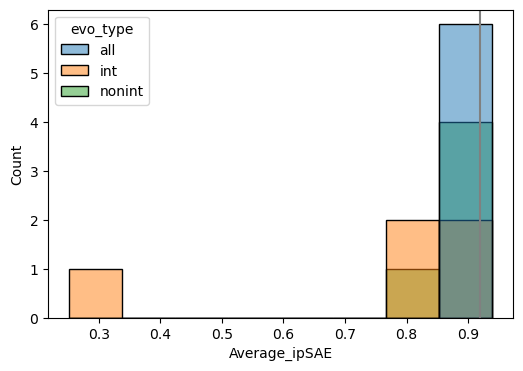

In [39]:
## Replace with your 
import matplotlib.pyplot as plt
parental_prediction_name = "BCMA_all_wildtype__BCMA"

## Replace with your own naming logic if necessary
boltz_bindcraft_style_df["evo_type"] = boltz_bindcraft_style_df["prediction_name"].apply(lambda x: x.split("_")[1])
parental_metric =  boltz_bindcraft_style_df[boltz_bindcraft_style_df["prediction_name"]==parental_prediction_name]["Average_ipSAE"].item()

fig,ax = plt.subplots(figsize=(6,4))
sns.histplot(data=boltz_bindcraft_style_df,x="Average_ipSAE",hue="evo_type",ax=ax)
ax.axvline(parental_metric,color="gray")

### 5.2 Check how many entries passed filters (possible that none has passed)


In [41]:
len(boltz_bindcraft_style_df[boltz_bindcraft_style_df["unmet_conditions_length"]==0])

8

In [43]:
## Look at which conditions are the most frequently unmet and adjust accordingly
unmet_items = [item for sublist in boltz_bindcraft_style_df['unmet_conditions'] for item in sublist]
unmet_counter = Counter(unmet_items)
unmet_freq_df = pd.DataFrame(unmet_counter.items(), columns=["item", "count"]).sort_values("count", ascending=False)
unmet_freq_df.columns = ["Filter name","# of Binder Failed filter"]
unmet_freq_df

## Make a copy of the filter and update accordingly

,Filter name,# of Binder Failed filter
3,2_n_InterfaceHbonds,4
4,2_n_InterfaceUnsatHbonds,3
13,1_n_InterfaceHbonds,3
11,1_n_InterfaceUnsatHbonds,2
12,Average_n_InterfaceHbonds,2
2,2_Surface_Hydrophobicity,1
0,Average_Surface_Hydrophobicity,1
6,1_monomer_lDDT,1
5,Average_monomer_lDDT,1
1,1_Surface_Hydrophobicity,1


### 5.3 Apply other additional post-hoc filters 

In [44]:
## Replace with your own filtering conditions
parental_prediction_name = "BCMA_all_wildtype__BCMA"

## Replace with your own filtering conditions
boltz_bindcraft_style_df_filtered = boltz_bindcraft_style_df[
(boltz_bindcraft_style_df["unmet_conditions_length"]==0)&
(boltz_bindcraft_style_df["binder_seq_net_charge"]<0)&
(boltz_bindcraft_style_df["Average_ipSAE"]>0.85) |
(boltz_bindcraft_style_df["binder_name"]==parental_prediction_name)
].sort_values("Average_ipSAE",ascending=False) ## Sorting from high to low by ipSAE is recommended

## If we want to enforce diversity in backbone
boltz_bindcraft_style_df_filtered["backbone_name"] = boltz_bindcraft_style_df_filtered["prediction_name"].apply(lambda x: x.split("_mpnn")[0])
boltz_bindcraft_style_df_filtered = boltz_bindcraft_style_df_filtered.drop_duplicates("backbone_name")
boltz_bindcraft_style_df_filtered

,prediction_name,Average_Binder_BetaSheet%,1_Binder_BetaSheet%,2_Binder_BetaSheet%,3_Binder_BetaSheet%,4_Binder_BetaSheet%,5_Binder_BetaSheet%,Average_Binder_Energy_Score,1_Binder_Energy_Score,2_Binder_Energy_Score,3_Binder_Energy_Score,4_Binder_Energy_Score,5_Binder_Energy_Score,Average_Binder_Helix%,1_Binder_Helix%,2_Binder_Helix%,3_Binder_Helix%,4_Binder_Helix%,5_Binder_Helix%,Average_Binder_Loop%,1_Binder_Loop%,2_Binder_Loop%,3_Binder_Loop%,4_Binder_Loop%,5_Binder_Loop%,Average_InterfaceAAs,1_InterfaceAAs,2_InterfaceAAs,3_InterfaceAAs,4_InterfaceAAs,5_InterfaceAAs,Average_InterfaceHbondsPercentage,1_InterfaceHbondsPercentage,2_InterfaceHbondsPercentage,3_InterfaceHbondsPercentage,4_InterfaceHbondsPercentage,5_InterfaceHbondsPercentage,Average_InterfaceUnsatHbondsPercentage,1_InterfaceUnsatHbondsPercentage,2_InterfaceUnsatHbondsPercentage,3_InterfaceUnsatHbondsPercentage,4_InterfaceUnsatHbondsPercentage,5_InterfaceUnsatHbondsPercentage,Average_Interface_BetaSheet%,1_Interface_BetaSheet%,2_Interface_BetaSheet%,3_Interface_BetaSheet%,4_Interface_BetaSheet%,5_Interface_BetaSheet%,Average_Interface_Helix%,1_Interface_Helix%,2_Interface_Helix%,3_Interface_Helix%,4_Interface_Helix%,5_Interface_Helix%,Average_Interface_Hydrophobicity,1_Interface_Hydrophobicity,2_Interface_Hydrophobicity,3_Interface_Hydrophobicity,4_Interface_Hydrophobicity,5_Interface_Hydrophobicity,Average_Interface_Loop%,1_Interface_Loop%,2_Interface_Loop%,3_Interface_Loop%,4_Interface_Loop%,5_Interface_Loop%,Average_Interface_SASA_%,1_Interface_SASA_%,2_Interface_SASA_%,3_Interface_SASA_%,4_Interface_SASA_%,5_Interface_SASA_%,Average_LIS,1_LIS,2_LIS,3_LIS,4_LIS,5_LIS,Average_PackStat,1_PackStat,2_PackStat,3_PackStat,4_PackStat,5_PackStat,Average_Relaxed_Clashes,1_Relaxed_Clashes,2_Relaxed_Clashes,3_Relaxed_Clashes,4_Relaxed_Clashes,5_Relaxed_Clashes,Average_ShapeComplementarity,1_ShapeComplementarity,2_ShapeComplementarity,3_ShapeComplementarity,4_ShapeComplementarity,5_ShapeComplementarity,Average_Surface_Hydrophobicity,1_Surface_Hydrophobicity,2_Surface_Hydrophobicity,3_Surface_Hydrophobicity,4_Surface_Hydrophobicity,5_Surface_Hydrophobicity,Average_Unrelaxed_Clashes,1_Unrelaxed_Clashes,2_Unrelaxed_Clashes,3_Unrelaxed_Clashes,4_Unrelaxed_Clashes,5_Unrelaxed_Clashes,Average_binder_monomer_RMSD,1_binder_monomer_RMSD,2_binder_monomer_RMSD,3_binder_monomer_RMSD,4_binder_monomer_RMSD,5_binder_monomer_RMSD,Average_chains_ptm_0,1_chains_ptm_0,2_chains_ptm_0,3_chains_ptm_0,4_chains_ptm_0,5_chains_ptm_0,Average_chains_ptm_1,1_chains_ptm_1,2_chains_ptm_1,3_chains_ptm_1,4_chains_ptm_1,5_chains_ptm_1,Average_complex_ipde,1_complex_ipde,2_complex_ipde,3_complex_ipde,4_complex_ipde,5_complex_ipde,Average_complex_iplddt,1_complex_iplddt,2_complex_iplddt,3_complex_iplddt,4_complex_iplddt,5_complex_iplddt,Average_complex_pde,1_complex_pde,2_complex_pde,3_complex_pde,4_complex_pde,5_complex_pde,Average_complex_plddt,1_complex_plddt,2_complex_plddt,3_complex_plddt,4_complex_plddt,5_complex_plddt,Average_confidence_score,1_confidence_score,2_confidence_score,3_confidence_score,4_confidence_score,5_confidence_score,Average_dG,1_dG,1_dG/dSASA,2_dG,2_dG/dSASA,3_dG,3_dG/dSASA,4_dG,4_dG/dSASA,5_dG,5_dG/dSASA,Average_dSASA,1_dSASA,2_dSASA,3_dSASA,4_dSASA,5_dSASA,Average_i_pLDDT,1_i_pLDDT,2_i_pLDDT,3_i_pLDDT,4_i_pLDDT,5_i_pLDDT,Average_ipSAE,1_ipSAE,2_ipSAE,3_ipSAE,4_ipSAE,5_ipSAE,Average_ipSAE_d0chn,1_ipSAE_d0chn,2_ipSAE_d0chn,3_ipSAE_d0chn,4_ipSAE_d0chn,5_ipSAE_d0chn,Average_ipSAE_d0dom,1_ipSAE_d0dom,2_ipSAE_d0dom,3_ipSAE_d0dom,4_ipSAE_d0dom,5_ipSAE_d0dom,Average_ipTM_af,1_ipTM_af,2_ipTM_af,3_ipTM_af,4_ipTM_af,5_ipTM_af,Average_ipTM_d0chn,1_ipTM_d0chn,2_ipTM_d0chn,3_ipTM_d0chn,4_ipTM_d0chn,5_ipTM_d0chn,Average_iptm,1_iptm,2_iptm,3_iptm,4_iptm,5_iptm,Average_ligand_iptm,1_ligand_iptm,2_ligand_iptm,3_ligand_iptm,4_ligand_iptm,5_ligand_iptm,Average_monomer_lDDT,1_monomer_lDDT,2_monomer_lDDT,3_monomer_lDDT,4_monomer_lDDT,5_monomer_lDDT,Average_n_InterfaceHbonds,1_n_InterfaceHbonds,2_n_In

### 5.4 Write the final binders to a directory

#### 5.4.1 Add binder paths back to the file

In [45]:
## Replace with your parental prediction name
parental_prediction_name = "BCMA_all_wildtype__BCMA"

top_binders = boltz_bindcraft_style_df_filtered
top_binders_merged = top_binders.merge(combined_boltz_df[["binder_name","pdb_path"]].drop_duplicates("binder_name"),how="left",on="binder_name")
top_binders_merged = top_binders_merged.rename(columns={"chain_a_seq":"binder_sequence"})
top_binders_merged.loc[top_binders_merged["prediction_name"]==parental_prediction_name,"evo_type"] = "parental"
top_binders_merged

,prediction_name,Average_Binder_BetaSheet%,1_Binder_BetaSheet%,2_Binder_BetaSheet%,3_Binder_BetaSheet%,4_Binder_BetaSheet%,5_Binder_BetaSheet%,Average_Binder_Energy_Score,1_Binder_Energy_Score,2_Binder_Energy_Score,3_Binder_Energy_Score,4_Binder_Energy_Score,5_Binder_Energy_Score,Average_Binder_Helix%,1_Binder_Helix%,2_Binder_Helix%,3_Binder_Helix%,4_Binder_Helix%,5_Binder_Helix%,Average_Binder_Loop%,1_Binder_Loop%,2_Binder_Loop%,3_Binder_Loop%,4_Binder_Loop%,5_Binder_Loop%,Average_InterfaceAAs,1_InterfaceAAs,2_InterfaceAAs,3_InterfaceAAs,4_InterfaceAAs,5_InterfaceAAs,Average_InterfaceHbondsPercentage,1_InterfaceHbondsPercentage,2_InterfaceHbondsPercentage,3_InterfaceHbondsPercentage,4_InterfaceHbondsPercentage,5_InterfaceHbondsPercentage,Average_InterfaceUnsatHbondsPercentage,1_InterfaceUnsatHbondsPercentage,2_InterfaceUnsatHbondsPercentage,3_InterfaceUnsatHbondsPercentage,4_InterfaceUnsatHbondsPercentage,5_InterfaceUnsatHbondsPercentage,Average_Interface_BetaSheet%,1_Interface_BetaSheet%,2_Interface_BetaSheet%,3_Interface_BetaSheet%,4_Interface_BetaSheet%,5_Interface_BetaSheet%,Average_Interface_Helix%,1_Interface_Helix%,2_Interface_Helix%,3_Interface_Helix%,4_Interface_Helix%,5_Interface_Helix%,Average_Interface_Hydrophobicity,1_Interface_Hydrophobicity,2_Interface_Hydrophobicity,3_Interface_Hydrophobicity,4_Interface_Hydrophobicity,5_Interface_Hydrophobicity,Average_Interface_Loop%,1_Interface_Loop%,2_Interface_Loop%,3_Interface_Loop%,4_Interface_Loop%,5_Interface_Loop%,Average_Interface_SASA_%,1_Interface_SASA_%,2_Interface_SASA_%,3_Interface_SASA_%,4_Interface_SASA_%,5_Interface_SASA_%,Average_LIS,1_LIS,2_LIS,3_LIS,4_LIS,5_LIS,Average_PackStat,1_PackStat,2_PackStat,3_PackStat,4_PackStat,5_PackStat,Average_Relaxed_Clashes,1_Relaxed_Clashes,2_Relaxed_Clashes,3_Relaxed_Clashes,4_Relaxed_Clashes,5_Relaxed_Clashes,Average_ShapeComplementarity,1_ShapeComplementarity,2_ShapeComplementarity,3_ShapeComplementarity,4_ShapeComplementarity,5_ShapeComplementarity,Average_Surface_Hydrophobicity,1_Surface_Hydrophobicity,2_Surface_Hydrophobicity,3_Surface_Hydrophobicity,4_Surface_Hydrophobicity,5_Surface_Hydrophobicity,Average_Unrelaxed_Clashes,1_Unrelaxed_Clashes,2_Unrelaxed_Clashes,3_Unrelaxed_Clashes,4_Unrelaxed_Clashes,5_Unrelaxed_Clashes,Average_binder_monomer_RMSD,1_binder_monomer_RMSD,2_binder_monomer_RMSD,3_binder_monomer_RMSD,4_binder_monomer_RMSD,5_binder_monomer_RMSD,Average_chains_ptm_0,1_chains_ptm_0,2_chains_ptm_0,3_chains_ptm_0,4_chains_ptm_0,5_chains_ptm_0,Average_chains_ptm_1,1_chains_ptm_1,2_chains_ptm_1,3_chains_ptm_1,4_chains_ptm_1,5_chains_ptm_1,Average_complex_ipde,1_complex_ipde,2_complex_ipde,3_complex_ipde,4_complex_ipde,5_complex_ipde,Average_complex_iplddt,1_complex_iplddt,2_complex_iplddt,3_complex_iplddt,4_complex_iplddt,5_complex_iplddt,Average_complex_pde,1_complex_pde,2_complex_pde,3_complex_pde,4_complex_pde,5_complex_pde,Average_complex_plddt,1_complex_plddt,2_complex_plddt,3_complex_plddt,4_complex_plddt,5_complex_plddt,Average_confidence_score,1_confidence_score,2_confidence_score,3_confidence_score,4_confidence_score,5_confidence_score,Average_dG,1_dG,1_dG/dSASA,2_dG,2_dG/dSASA,3_dG,3_dG/dSASA,4_dG,4_dG/dSASA,5_dG,5_dG/dSASA,Average_dSASA,1_dSASA,2_dSASA,3_dSASA,4_dSASA,5_dSASA,Average_i_pLDDT,1_i_pLDDT,2_i_pLDDT,3_i_pLDDT,4_i_pLDDT,5_i_pLDDT,Average_ipSAE,1_ipSAE,2_ipSAE,3_ipSAE,4_ipSAE,5_ipSAE,Average_ipSAE_d0chn,1_ipSAE_d0chn,2_ipSAE_d0chn,3_ipSAE_d0chn,4_ipSAE_d0chn,5_ipSAE_d0chn,Average_ipSAE_d0dom,1_ipSAE_d0dom,2_ipSAE_d0dom,3_ipSAE_d0dom,4_ipSAE_d0dom,5_ipSAE_d0dom,Average_ipTM_af,1_ipTM_af,2_ipTM_af,3_ipTM_af,4_ipTM_af,5_ipTM_af,Average_ipTM_d0chn,1_ipTM_d0chn,2_ipTM_d0chn,3_ipTM_d0chn,4_ipTM_d0chn,5_ipTM_d0chn,Average_iptm,1_iptm,2_iptm,3_iptm,4_iptm,5_iptm,Average_ligand_iptm,1_ligand_iptm,2_ligand_iptm,3_ligand_iptm,4_ligand_iptm,5_ligand_iptm,Average_monomer_lDDT,1_monomer_lDDT,2_monomer_lDDT,3_monomer_lDDT,4_monomer_lDDT,5_monomer_lDDT,Average_n_InterfaceHbonds,1_n_InterfaceHbonds,2_n_In

#### 5.4.2 Write the tsv file, pdb structures, and fastas into a directory

In [50]:
## Replace with your own output path
report_directory = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/04_final_selection"
report_name = "BCMAEvolvedBinders"


def write_report(data,report_dir,report_name="report",pdb_maps=None,id_col="barcode",seq_col="seq"):
    """
    Write report related entries like csv, pdbs, and pdf to the given directory
    pdb_maps are directory names plus the filepath column
    """
    os.makedirs(report_dir,exist_ok=True)
    ## TSV section
    report_tsv_path = os.path.join(report_dir,f"{report_name}.tsv")
    data.to_csv(report_tsv_path,sep="\t",index=False)
    ## PDB section
    if pdb_maps is not None:
        for dirname in pdb_maps:
            dest_dir = os.path.join(report_dir,dirname)
            os.makedirs(dest_dir,exist_ok=True)
            for idx,row in data.iterrows():
                pdb_path = row[pdb_maps[dirname]]
                if not os.path.exists(pdb_path):
                    print(f"Warning: {pdb_path} is not found")
                #print(f"Copying {pdb_path} to {dest_dir}")
                shutil.copy(pdb_path,dest_dir)
    ## FASTA section
    report_fasta_path = os.path.join(report_dir,f"{report_name}.fasta")
    df_to_fasta(data,id_col,seq_col,report_fasta_path)
    print("Done writing report")

def df_to_fasta(data,id_col,seq_col,out_file):
    """
    Convenience function to write 2 columns in dataframe into fasta file
    """
    with open(out_file, 'w') as fasta_file:
        for index, row in data.iterrows():
            to_write = f">{row[id_col]}\n{row[seq_col]}\n"
            fasta_file.write(to_write)

## If the pdb paths were relative, make them absolute
## Replace with your path or comment this out if not needed
top_binders_merged["pdb_path_absolute"] = "/data1/lareauc/users/chuh/softwares/CARPNN/" + top_binders_merged["pdb_path"]

write_report(
    top_binders_merged,
    report_dir=report_directory,
    report_name=report_name,
    id_col="binder_name",
    seq_col="binder_sequence",
    pdb_maps={
        #"boltz1_pdbs":"pdb_path",
        "boltz1_pdbs":"pdb_path_absolute"
    }
)

Done writing report


### (Optional) Visualize where the mutations were made

In [51]:
from matplotlib.colors import ListedColormap
def plot_mutation_matrix(
    sequences: list,
    reference: str,
    title: str = "Mutation Counts to Each Amino Acid per Position",
    show: bool = True,
    save_path: str = None,
    interface_residues_map: dict = None
):
    """
    Generate and plot a heatmap of mutations from reference to each amino acid at each position.
    Zero-count entries are colored white. X-axis ticks can be colored based on interface status.

    Parameters:
        sequences (list of str): List of aligned sequences of same length.
        reference (str): Reference sequence to compare against.
        title (str): Title for the plot.
        show (bool): Whether to display the plot.
        save_path (str): If provided, saves the plot to this file path.
        interface_residues_map (dict, optional): A dictionary mapping residue position (1-based)
            to its interface status ('interface' or 'non-interface'). If provided, the x-axis
            tick labels will be colored accordingly.
    
    Returns:
        pd.DataFrame: The mutation count matrix (20 x L).
    """
    aa_list = list("ACDEFGHIKLMNPQRSTVWY")
    L = len(reference)

    # Initialize mutation count matrix
    mut_matrix = pd.DataFrame(
        0, index=aa_list, columns=[f"{reference[i]}{i+1}" for i in range(L)]
    )

    for seq in sequences:
        if len(seq) != L:
            continue  # skip misaligned sequences
        for i, (ref_aa, alt_aa) in enumerate(zip(reference, seq)):
            if alt_aa != ref_aa and alt_aa in aa_list:
                mut_matrix.loc[alt_aa, f"{ref_aa}{i+1}"] += 1

    # Plot
    plt.figure(figsize=(L * 0.3, 6))
    
    # Create a custom colormap that makes 0 entries white
    viridis_cmap = plt.cm.get_cmap('viridis')
    new_colors = viridis_cmap(np.linspace(0, 1, 256))
    new_colors[0, :] = [1, 1, 1, 1]  # Set the first color (for 0) to white
    custom_cmap = ListedColormap(new_colors)

    sns.heatmap(
        mut_matrix, cmap=custom_cmap, linewidths=0.2, linecolor='gray',
        cbar_kws={'label': 'Mutation Count'}, annot=False, fmt='g',
        vmin=0  # Ensure the colormap starts at 0, mapping it to white
    )
    plt.title(title)
    plt.xlabel("Parental Residue Position")
    plt.ylabel("Mutated Amino Acid")
    plt.tight_layout()

    # Color the x-axis ticks if an interface map is provided
    if interface_residues_map:
        ax = plt.gca()
        xticklabels = ax.get_xticklabels()
        for label in xticklabels:
            # Extract position from the label (e.g., 'A1' -> '1')
            position = int("".join(filter(str.isdigit, label.get_text())))
            status = interface_residues_map.get(position)
            
            if status == 'interface':
                label.set_color('red')
            elif status == 'non-interface':
                label.set_color('blue')
            # You can add more conditions for other statuses if needed

    if save_path:
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

    return mut_matrix

In [52]:
## Replace with your interface residue jsonl
interface_residues_json_path = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/02_lead_candidate_mutagenized/input_structure/BCMA_l54_interface_residues.jsonl"

with open(interface_residues_json_path) as f:
    interface_residues_json =  json.load(f)
for key in interface_residues_json:
    interface_residues = interface_residues_json[key]

interface_residues_indices = [int(item[1:]) for item in interface_residues.split(" ")]
interface_residues_map = {
    idx:"interface" if idx in interface_residues_indices else "non-interface" 
    for idx in range(1,len(top_binders_merged["binder_sequence"].iloc[0])+1)
}
interface_residues_map

{1: 'non-interface',
 2: 'non-interface',
 3: 'non-interface',
 4: 'non-interface',
 5: 'interface',
 6: 'interface',
 7: 'non-interface',
 8: 'non-interface',
 9: 'interface',
 10: 'interface',
 11: 'non-interface',
 12: 'non-interface',
 13: 'interface',
 14: 'interface',
 15: 'non-interface',
 16: 'non-interface',
 17: 'interface',
 18: 'interface',
 19: 'non-interface',
 20: 'interface',
 21: 'interface',
 22: 'non-interface',
 23: 'non-interface',
 24: 'non-interface',
 25: 'non-interface',
 26: 'non-interface',
 27: 'interface',
 28: 'non-interface',
 29: 'non-interface',
 30: 'interface',
 31: 'interface',
 32: 'non-interface',
 33: 'non-interface',
 34: 'interface',
 35: 'interface',
 36: 'non-interface',
 37: 'non-interface',
 38: 'non-interface',
 39: 'non-interface',
 40: 'interface',
 41: 'interface',
 42: 'non-interface',
 43: 'interface',
 44: 'interface',
 45: 'non-interface',
 46: 'non-interface',
 47: 'interface',
 48: 'non-interface',
 49: 'non-interface',
 50: 'non-i

/tmp/ipykernel_3291068/2340849253.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = plt.cm.get_cmap('viridis')


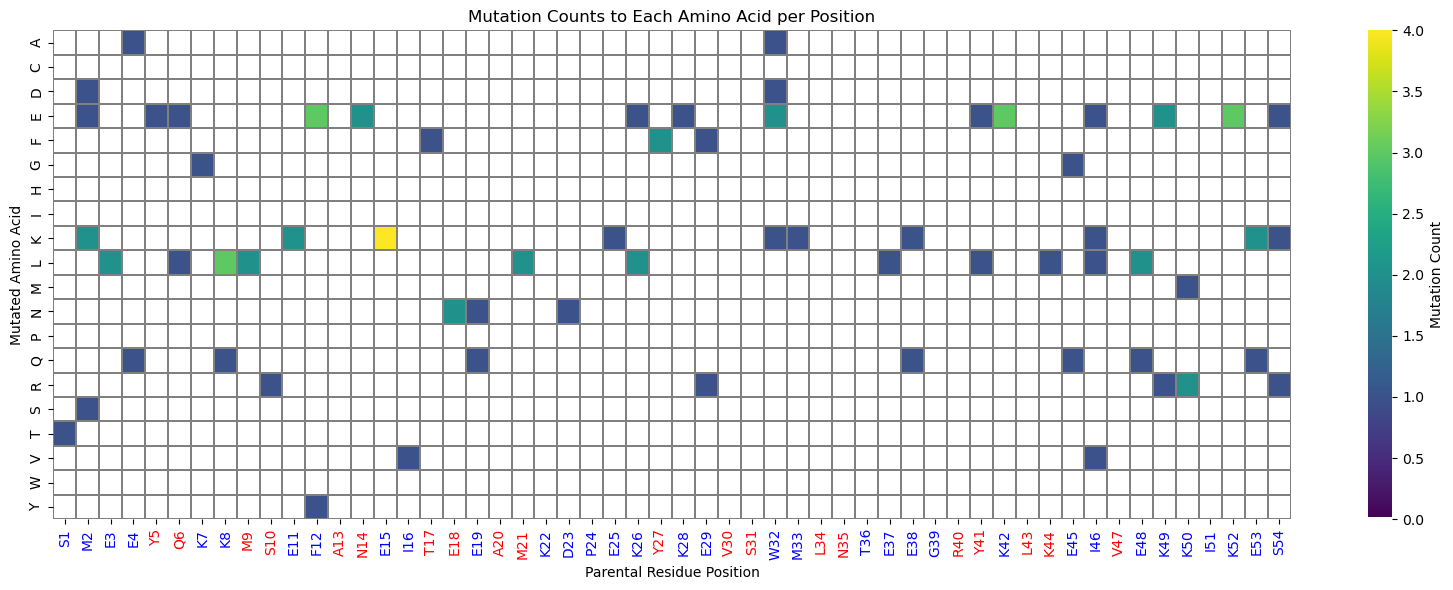

,S1,M2,E3,E4,Y5,Q6,K7,K8,M9,S10,E11,F12,A13,N14,E15,I16,T17,E18,E19,A20,M21,K22,D23,P24,E25,K26,Y27,K28,E29,V30,S31,W32,M33,L34,N35,T36,E37,E38,G39,R40,Y41,K42,L43,K44,E45,I46,V47,E48,K49,K50,I51,K52,E53,S54
A,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
E,0,1,0,0,1,1,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,3,0,0,0,1,0,0,2,0,0,3,0,1
F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
K,0,2,0,0,0,0,0,0,0,0,2,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1
L,0,0,2,0,0,1,0,3,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,2,0,0,0,0,0,0


In [54]:
# Replace with your own pdf save path
pdf_save_path = "/data1/lareauc/users/chuh/softwares/CARPNN/examples/04_final_selection/BCMA_parental_mutations.pdf"

final_seqs = top_binders_merged["binder_sequence"].tolist()
reference_seq = top_binders_merged[top_binders_merged["evo_type"]=="parental"]["binder_sequence"].item()
plot_mutation_matrix(final_seqs, reference_seq, interface_residues_map=interface_residues_map,
                     save_path=pdf_save_path)
                     